In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

### Dataloader and Window(30 sec, 15 sec Overlap)

In [2]:


# 경로 설정
base_path = 'D:/LabRoom/Projects/SD Physiology/Processed/processed_individual'
participant_list = sorted(list(set(f.split("_")[0] for f in os.listdir(base_path) if f.endswith("_Main.pkl"))))

# 파라미터 설정
fps = 120
window_seconds = 30
stride_seconds = 15

window_size = window_seconds * fps
stride_size = stride_seconds * fps


# Step 1️⃣: 데이터 불러오기 및 Outside 필터링
data_dict = {}

for name in tqdm(participant_list, desc="Loading and Filtering"):
    file_path = os.path.join(base_path, f"{name}_Main.pkl")
    try:
        df = pd.read_pickle(file_path)
        df_outside = df[df['scene'] == 'Outside'].copy()
        if len(df_outside) >= window_size:
            data_dict[name] = df_outside
    except Exception as e:
        print(f"{name}: 오류 발생 - {e}")
        


Loading and Filtering: 100%|██████████| 108/108 [02:01<00:00,  1.12s/it]


### Feature Selection

In [3]:

# Step 0️⃣: 예시 participant로부터 column 구조만 추출
sample_name = participant_list[0]
sample_df = pd.read_pickle(os.path.join(base_path, f"{sample_name}_Main.pkl"))
sample_df = sample_df[sample_df['scene'] == 'Outside'].copy()
sample_df.reset_index(drop=True, inplace=True)

exclude_keywords = [
    'unit',       # face tracker
    'Frame',      # 단순 index
    'X_pos', 'Y_pos', 'Z_pos',     # 위치 좌표
    'X_rot', 'Y_rot', 'Z_rot',     # 회전값
    'validL', 'validR',            # 눈 추적 유효 여부 (bool성태 숫자)
    'gazeorigin', 'gazeL_', 'gazeR_',  # 시선 방향 좌표
    'pupilLSensorPos',             # 동공 센서 위치
     'eye_openness'
]
feature_cols = [
    col for col in sample_df.columns
    if (
        col not in ['anxiety', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        sample_df[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

Generating Windows: 100%|██████████| 108/108 [00:13<00:00,  8.11it/s]


✅ 최종 window 수: 2300
🚫 NaN 때문에 제외된 window 수: 56


participant  start_idx                note
0     nsk9105          0  All NaN in anxiety
1     nsk9105       1800  All NaN in anxiety
2     nsk9105       3600  All NaN in anxiety
3     nsk9105       5400  All NaN in anxiety
4     nsk9105       7200  All NaN in anxiety

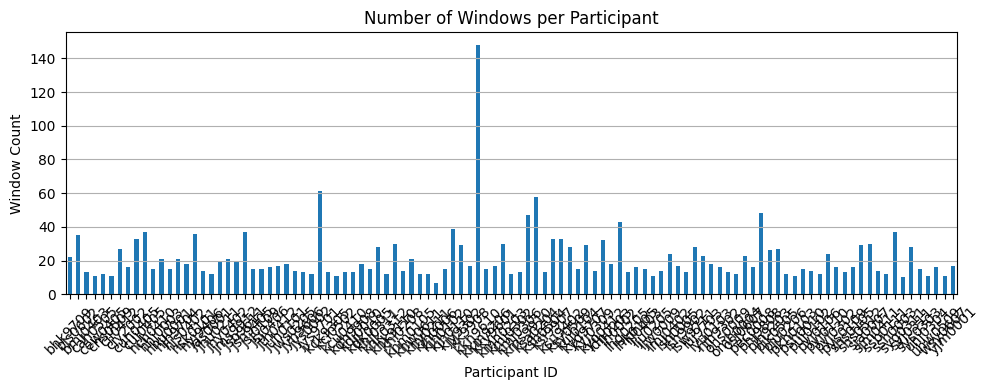

In [4]:
windowed_data = []
nan_log = []  # NaN 로그 저장
for name, df in tqdm(data_dict.items(), desc="Generating Windows"):
    df = df.reset_index(drop=True)
    for start in range(0, len(df) - window_size + 1, stride_size):
        end = start + window_size
        window_df = df.iloc[start:end]

        anxiety_values = window_df["anxiety"]
        anxiety_mean = anxiety_values.mean()

        # NaN인지 먼저 확인
        if np.isnan(anxiety_mean):
            nan_log.append({
                "participant": name,
                "start_idx": start,
                "note": "All NaN in anxiety"
            })
            continue  # 이 window는 skip

        features = {}
        for col in feature_cols:
            features[f"{col}_mean"] = window_df[col].mean()
            features[f"{col}_std"] = window_df[col].std()

        features["anxiety_mean"] = anxiety_mean
        features["participant"] = name
        features["start_idx"] = start
        windowed_data.append(features)

# 결과 저장
window_df_all = pd.DataFrame(windowed_data)
nan_log_df = pd.DataFrame(nan_log)

print(f"\n✅ 최종 window 수: {len(window_df_all)}")
print(f"🚫 NaN 때문에 제외된 window 수: {len(nan_log_df)}")

# 필요 시 확인
display(nan_log_df.head())


# Step 4️⃣: 참가자별 window 수 시각화
participant_counts = window_df_all['participant'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
participant_counts.plot(kind='bar')
plt.title("Number of Windows per Participant")
plt.xlabel("Participant ID")
plt.ylabel("Window Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [5]:
# 🔹 1. feature column 목록 정리 (불필요한 열 제거)
feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety_mean', 'participant', 'start_idx']
]

# 🔹 2. 상관관계 행렬 계산 (절댓값 기준)
corr_matrix = window_df_all[feature_cols].corr().abs()

# 🔹 3. 상삼각행렬로 중복 제거
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 🔹 4. 상관계수 0.95 초과하는 column 목록 수집
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# 🔹 5. 필터링된 feature 목록
filtered_features = [col for col in feature_cols if col not in to_drop]

print(f"💡 제거된 중복 feature 수: {len(to_drop)}")
print(f"✅ 최종 feature 수: {len(filtered_features)}")
# feature_cols = filtered_features

💡 제거된 중복 feature 수: 19
✅ 최종 feature 수: 39


In [6]:
window_df_all = window_df_all[window_df_all["participant"] != "nsk9105"].reset_index(drop=True)

print(f"🚫 NaN 포함 참가자 'nsk9105' 제거 후 window 수: {len(window_df_all)}")

🚫 NaN 포함 참가자 'nsk9105' 제거 후 window 수: 2300


In [7]:
len(window_df_all['participant'].unique())  # 참가자 목록 확인

107

In [8]:
# 참가자별 window 개수 집계
participant_counts = window_df_all['participant'].value_counts()

# 5개 미만인 참가자만 추출
too_short = participant_counts[participant_counts < 5]

# 결과 출력
print(f"🚫 너무 짧은 참가자 수 (<5 windows): {len(too_short)}명")
display(too_short)

🚫 너무 짧은 참가자 수 (<5 windows): 0명


Series([], Name: count, dtype: int64)

### Data split

In [102]:
# participant별 split (80/10/10)
participant_groups = window_df_all.groupby("participant")

train_list, val_list, test_list = [], [], []

for pid, group in participant_groups:
    group_sorted = group.sort_values("start_idx").reset_index(drop=True)
    n = len(group_sorted)
    n_train = int(n * 0.8)
    n_val = int(n * 0.1)

    # 시간순 split
    train = group_sorted.iloc[:n_train]
    val = group_sorted.iloc[n_train:n_train + n_val]
    test = group_sorted.iloc[n_train + n_val:]

    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

# 합치기
train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 1793, Val size: 183, Test size: 324


### Run

In [103]:
print(train_df['anxiety_mean'].isna().sum())
print(val_df['anxiety_mean'].isna().sum())
print(test_df['anxiety_mean'].isna().sum())

0
0
0


In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 사용 feature 목록 자동 선택
feature_cols = [col for col in train_df.columns 
                if (col.endswith('_mean') or col.endswith('_std')) 
                and col != "anxiety_mean"]
X_train = train_df[feature_cols]
y_train = train_df["anxiety_mean"]

X_val = val_df[feature_cols]
y_val = val_df["anxiety_mean"]

X_test = test_df[feature_cols]
y_test = test_df["anxiety_mean"]

# 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


MAE: 2.082, RMSE: 2.606, R²: -0.048


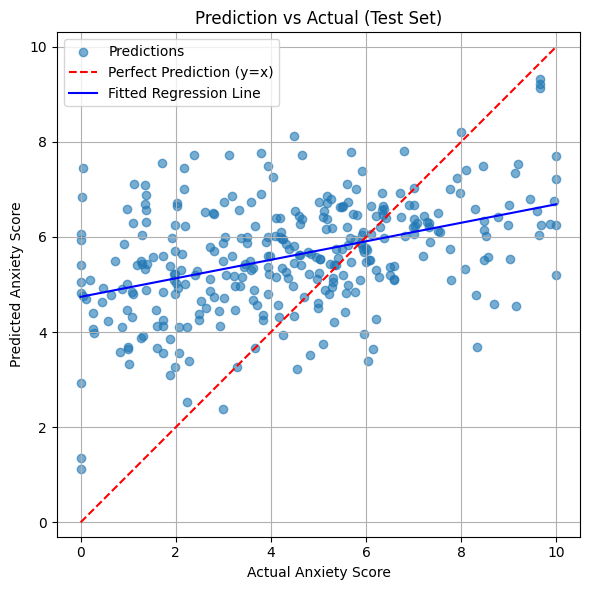

In [105]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Fit line
line_model = LinearRegression().fit(y_test.values.reshape(-1, 1), y_pred)
pred_line = line_model.predict(np.array([min_val, max_val]).reshape(-1, 1))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions')
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction (y=x)')
plt.plot([min_val, max_val], pred_line, 'b-', label='Fitted Regression Line')
plt.xlabel("Actual Anxiety Score")
plt.ylabel("Predicted Anxiety Score")
plt.title("Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [106]:
train_df[feature_cols].columns

Index(['pupilL_mean', 'pupilL_std', 'pupilR_mean', 'pupilR_std',
       'PPG_Raw_mean', 'PPG_Raw_std', 'PPG_Clean_mean', 'PPG_Clean_std',
       'PPG_Rate_mean', 'PPG_Rate_std', 'PPG_Quality_mean', 'PPG_Quality_std',
       'PPG_Peaks_mean', 'PPG_Peaks_std', 'EDA_Raw_mean', 'EDA_Raw_std',
       'EDA_Clean_mean', 'EDA_Clean_std', 'EDA_Tonic_mean', 'EDA_Tonic_std',
       'EDA_Phasic_mean', 'EDA_Phasic_std', 'SCR_Onsets_mean',
       'SCR_Onsets_std', 'SCR_Peaks_mean', 'SCR_Peaks_std', 'SCR_Height_mean',
       'SCR_Height_std', 'SCR_Amplitude_mean', 'SCR_Amplitude_std',
       'SCR_RiseTime_mean', 'SCR_RiseTime_std', 'SCR_Recovery_mean',
       'SCR_Recovery_std', 'SCR_RecoveryTime_mean', 'SCR_RecoveryTime_std',
       'RSP_Raw_mean', 'RSP_Raw_std', 'RSP_Clean_mean', 'RSP_Clean_std',
       'RSP_Amplitude_mean', 'RSP_Amplitude_std', 'RSP_Rate_mean',
       'RSP_Rate_std', 'RSP_RVT_mean', 'RSP_RVT_std', 'RSP_Phase_mean',
       'RSP_Phase_std', 'RSP_Phase_Completion_mean',
       'RSP_P

MAE: 1.465, RMSE: 1.853, R²: 0.486


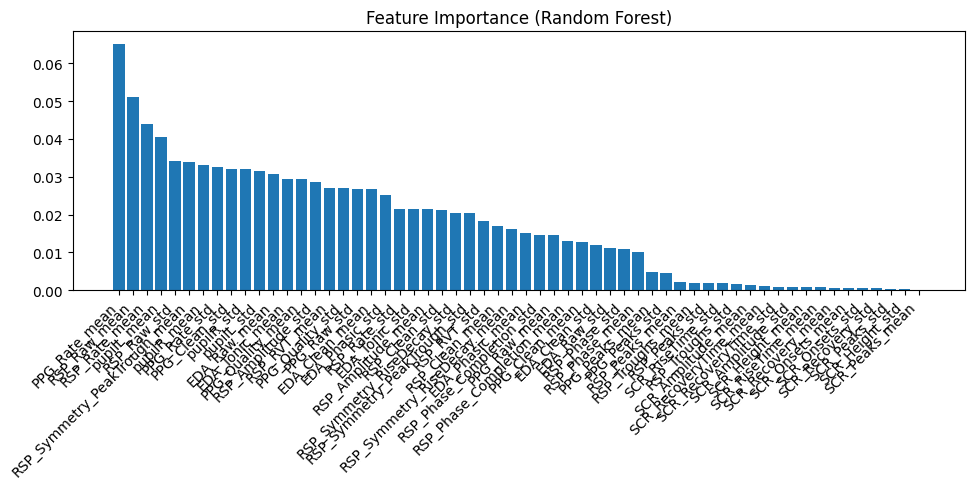

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 🎯 1. Feature 선택
feature_cols = [col for col in window_df_all.columns 
                if (col.endswith('_mean') or col.endswith('_std')) 
                and col != "anxiety_mean"]

# 🧼 2. NaN 제거된 상태의 데이터 재분할 (participant 단위 split 생략하고 전체 랜덤 split 예시)
from sklearn.model_selection import train_test_split
X = window_df_all[feature_cols]
y = window_df_all["anxiety_mean"]

# (선택) Feature scaling (RandomForest는 필요 없음, 다른 모델 대비용)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🌳 3. 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 🧪 4. 예측 및 평가
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

# 📊 5. Feature Importance 시각화
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [feature_cols[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(range(len(top_features)), importances[indices])
plt.xticks(range(len(top_features)), top_features, rotation=45, ha='right')
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


In [108]:
# 중요도 상위 20개 feature만 추출
top_n = 20
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top20_features = [feature_cols[i] for i in indices[:top_n]]

# X 재정의
X = window_df_all[top20_features]
y = window_df_all['anxiety_mean']

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 모델 학습
from sklearn.ensemble import RandomForestRegressor
model_top = RandomForestRegressor(random_state=42)
model_top.fit(X_train, y_train)

# 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model_top.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


MAE: 1.370, RMSE: 1.745, R²: 0.544


In [109]:
# 중요도 상위 20개 feature만 추출
top_n = 10
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top20_features = [feature_cols[i] for i in indices[:top_n]]

# X 재정의
X = window_df_all[top20_features]
y = window_df_all['anxiety_mean']

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 모델 학습
from sklearn.ensemble import RandomForestRegressor
model_top = RandomForestRegressor(random_state=42)
model_top.fit(X_train, y_train)

# 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model_top.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


MAE: 1.417, RMSE: 1.814, R²: 0.508


In [118]:
# 중요도 상위 20개 feature만 추출
top_n = 12
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top20_features = [feature_cols[i] for i in indices[:top_n]]

# X 재정의
X = window_df_all[top20_features]
y = window_df_all['anxiety_mean']

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 모델 학습
from sklearn.ensemble import RandomForestRegressor
model_top = RandomForestRegressor(random_state=42)
model_top.fit(X_train, y_train)

# 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model_top.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


MAE: 1.272, RMSE: 1.630, R²: 0.603


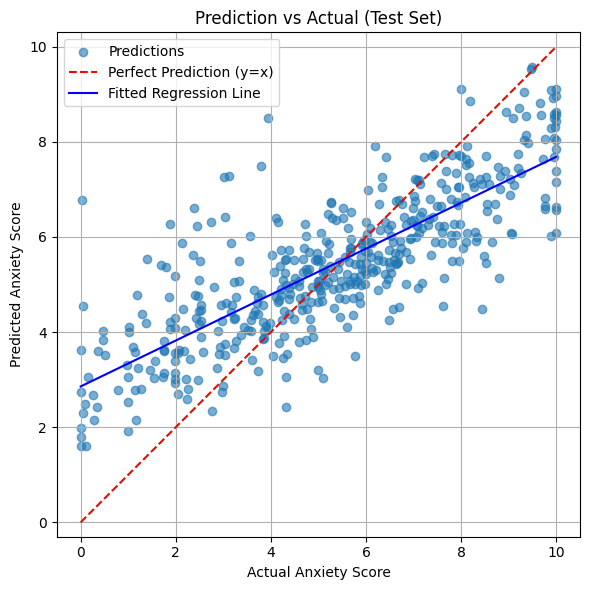

In [119]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Fit line
line_model = LinearRegression().fit(y_test.values.reshape(-1, 1), y_pred)
pred_line = line_model.predict(np.array([min_val, max_val]).reshape(-1, 1))

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predictions')
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction (y=x)')
plt.plot([min_val, max_val], pred_line, 'b-', label='Fitted Regression Line')
plt.xlabel("Actual Anxiety Score")
plt.ylabel("Predicted Anxiety Score")
plt.title("Prediction vs Actual (Test Set)")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


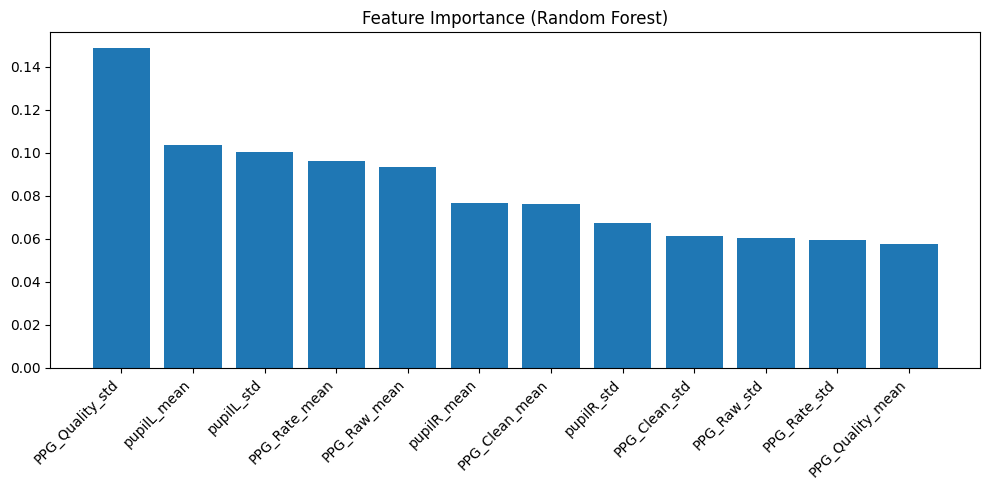

In [120]:
importances = model_top.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = [feature_cols[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.bar(range(len(top_features)), importances[indices])
plt.xticks(range(len(top_features)), top_features, rotation=45, ha='right')
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

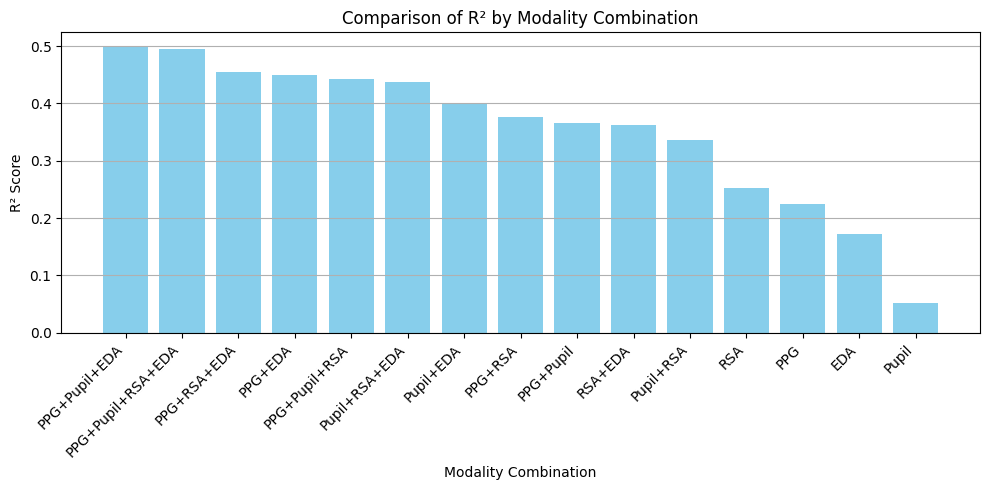

In [121]:
import itertools
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ 제외할 키워드 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

# ✅ 사용할 feature 추출
valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality별 컬럼 분류
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ 모든 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ 실험 결과 저장
results = []
model_save_dir = "./saved_models_filtered"
os.makedirs(model_save_dir, exist_ok=True)

# ✅ 조합별 루프
for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    X = window_df_all[selected_features]
    y = window_df_all["anxiety_mean"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Modality_Combination": combo_name,
        "Feature_Count": len(selected_features),
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

    model_path = os.path.join(model_save_dir, f"model_{combo_name.replace('+', '_')}.joblib")
    joblib.dump(model, model_path)

# ✅ 결과 데이터프레임 생성 및 저장
results_df = pd.DataFrame(results)
results_df.to_csv("modality_combinations_results.csv", index=False)

# ✅ 시각화: R² 기준 성능 비교
plt.figure(figsize=(10, 5))
sorted_df = results_df.sort_values(by="R2", ascending=False)
plt.bar(sorted_df["Modality_Combination"], sorted_df["R2"], color="skyblue")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination")
plt.ylabel("R² Score")
plt.title("Comparison of R² by Modality Combination")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_88340\153185954.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:20], y=sorted_features[:20], palette="Blues_d")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_88340\153185954.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:20], y=sorted_features[:20], palette="Blues_d")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_88340\153185954.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:20], y=sorted_features[:20],

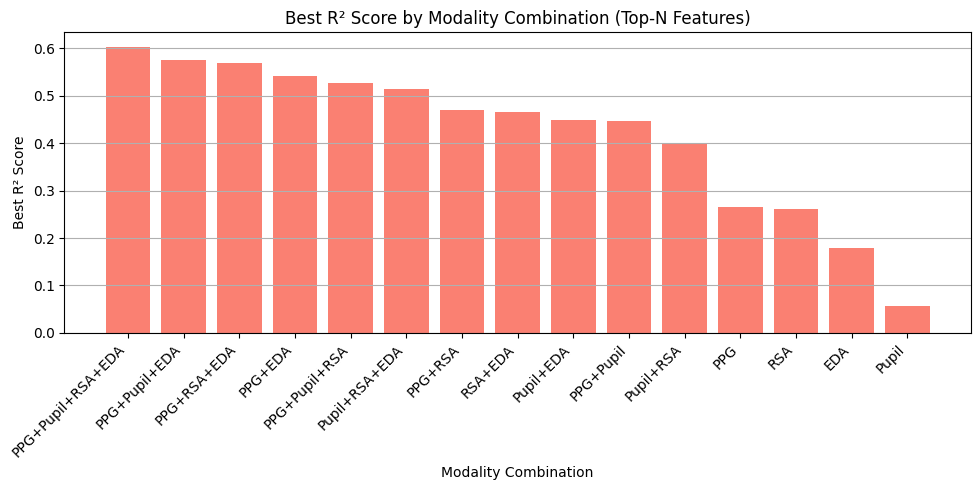

In [ ]:
import itertools
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ 제외할 키워드 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

# ✅ 유효한 feature 컬럼 추출
valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 정의
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ 결과 저장 초기화
best_results = []
importance_plot_dir = "./modality_importance_plots"
os.makedirs(importance_plot_dir, exist_ok=True)

# ✅ 각 조합별 반복
for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    X = window_df_all[selected_features]
    y = window_df_all["anxiety_mean"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 전체 feature로 학습 후 importance 추출
    full_model = RandomForestRegressor(random_state=42)
    full_model.fit(X_train, y_train)
    importances = full_model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [selected_features[i] for i in sorted_idx]

    # # 1️⃣ 중요도 시각화 저장
    # plt.figure(figsize=(10, 4))
    # sns.barplot(x=importances[sorted_idx][:20], y=sorted_features[:20], palette="Blues_d")
    # plt.title(f"Top Feature Importance: {combo_name}")
    # plt.xlabel("Importance")
    # plt.tight_layout()
    # plt.savefig(os.path.join(importance_plot_dir, f"importance_{combo_name}.png"))
    # plt.close()

    # 2️⃣ N개씩 사용해 성능 비교
    best_r2 = -np.inf
    best_result = None

    for top_n in range(3, len(sorted_features) + 1):
        top_features = sorted_features[:top_n]
        X_top = X[top_features]
        X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
            X_top, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor(random_state=42)
        model.fit(X_train_top, y_train_top)
        y_pred = model.predict(X_test_top)
        mae = mean_absolute_error(y_test_top, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_top, y_pred))
        r2 = r2_score(y_test_top, y_pred)

        if r2 > best_r2:
            best_result = {
                "Modality_Combination": combo_name,
                "Best_N": top_n,
                "R2": r2,
                "MAE": mae,
                "RMSE": rmse,
                "Top_Features": top_features
            }
            best_r2 = r2

    best_results.append(best_result)

# ✅ 전체 결과 정리
best_df = pd.DataFrame(best_results)
best_df.to_csv("best_feature_selection_results.csv", index=False)

# ✅ 2️⃣ 전체 조합 중 최고 R² 비교 시각화
plt.figure(figsize=(10, 5))
sorted_best = best_df.sort_values(by="R2", ascending=False)
plt.bar(sorted_best["Modality_Combination"], sorted_best["R2"], color="salmon")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination")
plt.ylabel("Best R² Score")
plt.title("Best R² Score by Modality Combination (Top-N Features)")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("best_r2_by_combination.png")
plt.show()


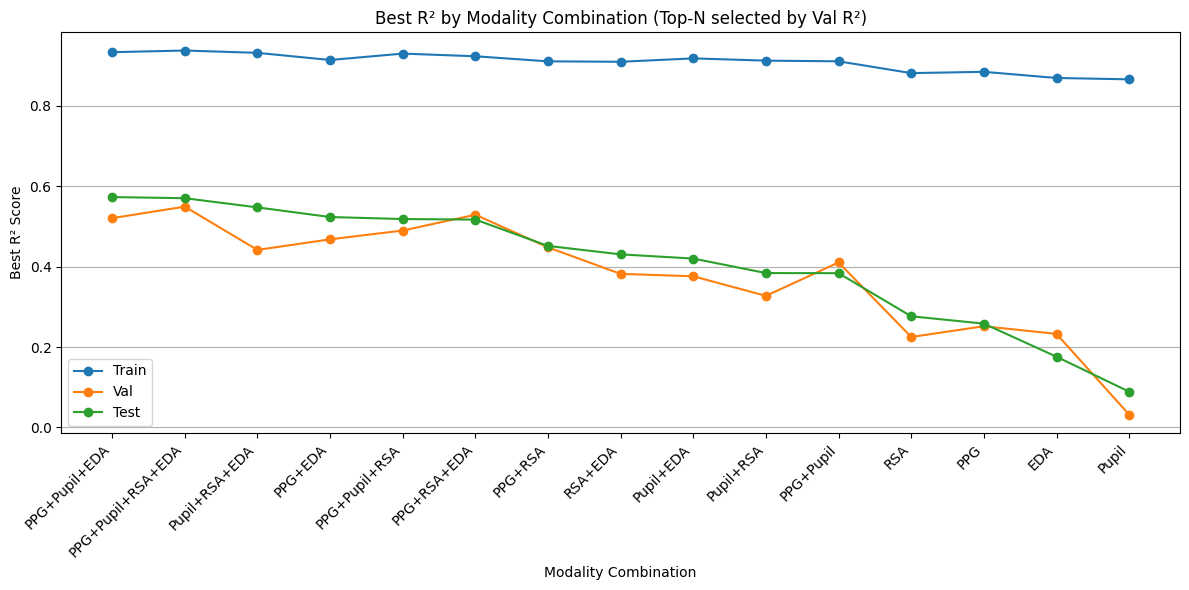

In [134]:
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ 제외할 키워드 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

# ✅ 유효한 feature 컬럼 추출
valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 정의
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ 결과 저장용
performance_records = []

# ✅ 각 조합별 루프
for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    X = window_df_all[selected_features]
    y = window_df_all["anxiety_mean"]

    # 먼저 10%를 test로 분리
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # 남은 90%에서 다시 10%를 validation으로 분리 → 전체의 9%
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)


    # ✅ feature importance 기반 정렬
    model_full = RandomForestRegressor(random_state=42)
    model_full.fit(X_train, y_train)
    importances = model_full.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [selected_features[i] for i in sorted_idx]

    # ✅ 1. Validation 성능 기준 best top-N 선택
    best_val_r2 = -np.inf
    best_n = None
    best_features = None
    for top_n in range(3, len(sorted_features) + 1):
        top_features = sorted_features[:top_n]
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train[top_features], y_train)
        val_pred = model.predict(X_val[top_features])
        val_r2 = r2_score(y_val, val_pred)
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_n = top_n
            best_features = top_features

    # ✅ 2. 선택된 top-N feature로 Train/Val/Test 평가
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train[best_features], y_train)
    for split_name, X_, y_ in zip(["Train", "Val", "Test"],
                                  [X_train[best_features], X_val[best_features], X_test[best_features]],
                                  [y_train, y_val, y_test]):
        y_pred = model.predict(X_)
        r2 = r2_score(y_, y_pred)
        mae = mean_absolute_error(y_, y_pred)
        rmse = np.sqrt(mean_squared_error(y_, y_pred))
        performance_records.append({
            "Modality": combo_name,
            "TopN": best_n,
            "Split": split_name,
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse
        })

# ✅ 결과 시각화
perf_df = pd.DataFrame(performance_records)

# 정렬: Test R² 기준 내림차순
best_by_split = (
    perf_df.sort_values(["Modality", "Split", "R2"], ascending=[True, True, False])
    .drop_duplicates(subset=["Modality", "Split"], keep="first")
)
pivot_df = best_by_split.pivot(index="Modality", columns="Split", values="R2")
pivot_df = pivot_df.sort_values(by="Test", ascending=False)

plt.figure(figsize=(12, 6))
for split in ["Train", "Val", "Test"]:
    if split in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[split], marker='o', label=split)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination")
plt.ylabel("Best R² Score")
plt.title("Best R² by Modality Combination (Top-N selected by Val R²)")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.savefig("best_r2_by_modality_valbased_sorted.png")
plt.show()


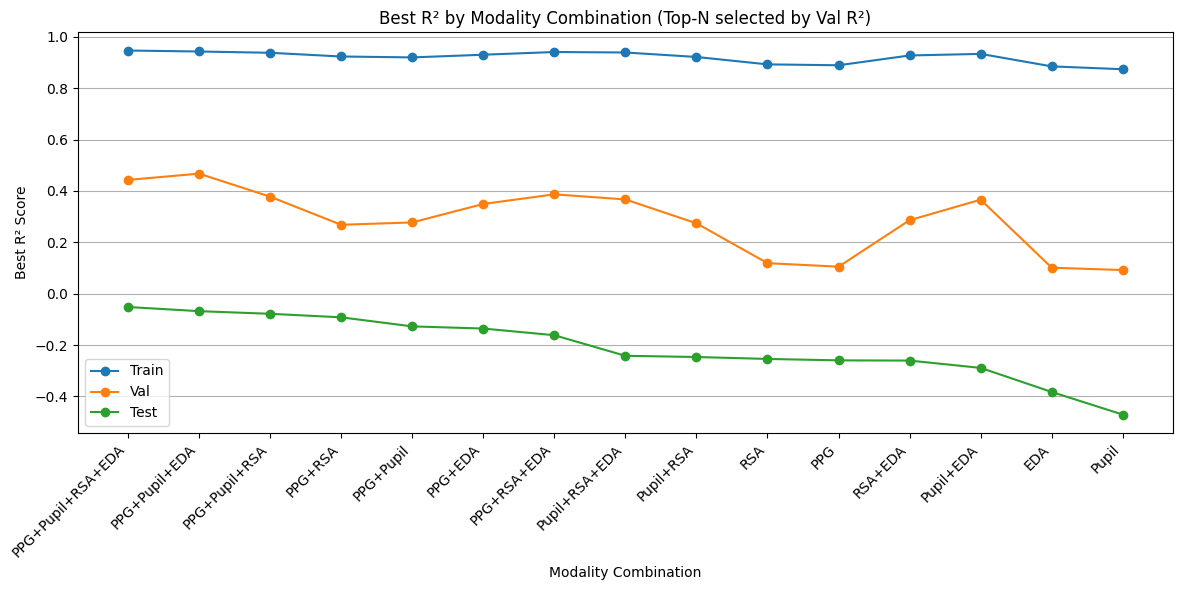

In [137]:
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ 제외할 키워드 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

# ✅ 유효한 feature 컬럼 추출
valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 정의
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ 결과 저장용
performance_records = []

# ✅ 각 조합별 루프
for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    # ✅ 참여자별로 split 후 합치기
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []
    X_test_list, y_test_list = [], []

    for pid, df_part in window_df_all.groupby("participant"):
        X_part = df_part[selected_features]
        y_part = df_part["anxiety_mean"]

        n_total = len(X_part)
        if n_total < 10:
            continue  # 너무 짧은 참여자는 제외

        idx_val_start = int(n_total * 0.8)
        idx_test_start = int(n_total * 0.9)

        X_train_list.append(X_part.iloc[:idx_val_start])
        y_train_list.append(y_part.iloc[:idx_val_start])

        X_val_list.append(X_part.iloc[idx_val_start:idx_test_start])
        y_val_list.append(y_part.iloc[idx_val_start:idx_test_start])

        X_test_list.append(X_part.iloc[idx_test_start:])
        y_test_list.append(y_part.iloc[idx_test_start:])

    # ✅ 전체 데이터 합치기
    X_train = pd.concat(X_train_list, axis=0)
    y_train = pd.concat(y_train_list, axis=0)
    X_val = pd.concat(X_val_list, axis=0)
    y_val = pd.concat(y_val_list, axis=0)
    X_test = pd.concat(X_test_list, axis=0)
    y_test = pd.concat(y_test_list, axis=0)

    # ✅ feature importance 기반 정렬
    model_full = RandomForestRegressor(random_state=42)
    model_full.fit(X_train, y_train)
    importances = model_full.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [selected_features[i] for i in sorted_idx]

    # ✅ 1. Validation 성능 기준 best top-N 선택
    best_val_r2 = -np.inf
    best_n = None
    best_features = None
    for top_n in range(3, len(sorted_features) + 1):
        top_features = sorted_features[:top_n]
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train[top_features], y_train)
        val_pred = model.predict(X_val[top_features])
        val_r2 = r2_score(y_val, val_pred)
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_n = top_n
            best_features = top_features

    # ✅ 2. 선택된 top-N feature로 Train/Val/Test 평가
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train[best_features], y_train)
    for split_name, X_, y_ in zip(["Train", "Val", "Test"],
                                  [X_train[best_features], X_val[best_features], X_test[best_features]],
                                  [y_train, y_val, y_test]):
        y_pred = model.predict(X_)
        r2 = r2_score(y_, y_pred)
        mae = mean_absolute_error(y_, y_pred)
        rmse = np.sqrt(mean_squared_error(y_, y_pred))
        performance_records.append({
            "Modality": combo_name,
            "TopN": best_n,
            "Split": split_name,
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse
        })

# ✅ 결과 시각화
perf_df = pd.DataFrame(performance_records)

# 정렬: Test R² 기준 내림차순
best_by_split = (
    perf_df.sort_values(["Modality", "Split", "R2"], ascending=[True, True, False])
    .drop_duplicates(subset=["Modality", "Split"], keep="first")
)
pivot_df = best_by_split.pivot(index="Modality", columns="Split", values="R2")
pivot_df = pivot_df.sort_values(by="Test", ascending=False)

plt.figure(figsize=(12, 6))
for split in ["Train", "Val", "Test"]:
    if split in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[split], marker='o', label=split)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination")
plt.ylabel("Best R² Score")
plt.title("Best R² by Modality Combination (Top-N selected by Val R²)")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.savefig("best_r2_by_modality_valbased_sorted.png")
plt.show()


In [11]:
window_df_all

pupilL_mean  pupilL_std  pupilR_mean  pupilR_std  PPG_Raw_mean  \
0        3.535387    0.951745     3.514824    0.929619      0.028515   
1        3.635164    1.143266     3.591151    1.133279      0.061006   
2        3.538640    1.212003     3.447212    1.185647      0.044282   
3        3.509464    1.221175     3.386575    1.171262      0.035735   
4        3.707704    1.212888     3.545053    1.146004      0.034675   
...           ...         ...          ...         ...           ...   
2295     3.945354    1.633895     4.036067    1.512230      0.036283   
2296     3.792688    1.604239     3.808079    1.357686      0.035994   
2297     3.827599    1.465830     3.804627    1.213546      0.035050   
2298     3.660895    1.195093     3.574408    1.157371      0.033237   
2299     3.431335    1.134606     3.401828    0.991107      0.034685   

      PPG_Raw_std  PPG_Clean_mean  PPG_Clean_std  PPG_Rate_mean  PPG_Rate_std  \
0        0.774338       -0.002428       0.663453      79.798493      7.149563   
1        0.600799        0.010035       0.469510      80.496823      7.591217   
2        0.426336        0.001874       0.423910      82.334116      3.944406   
3        0.556000       -0.001552       0.553919      81.448231      2.836463   
4        0.603205        0.000501       0.600585      79.984884      3.037781   
...           ...             ...            ...            ...           ...   
2295     0.169793        0.000799       0.160178      83.050174      3.867562   
2296     0.352549        0.000110       0.278115      85.850665      4.288681   
2297     0.353502        0.002825       0.282632      87.437784      5.182237   
2298     0.320397       -0.003792       0.279069      80.102911     18.304017   
2299     0.332600       -0.003611       0.278516      66.817538     23.539090   

      ...  RSP_Symmetry_PeakTrough_std  RSP_Symmetry_RiseDecay_mean  \
0     ...                     0.132534                     0.482997   
1     ...                     0.147103                     0.494769   
2     ...                     0.147667                     0.451113   
3     ...                     0.113679                     0.388130   
4     ...                     0.058198                     0.457867   
...   ...                          ...                          ...   
2295  ...                     0.042122                     0.374199   
2296  ...                     0.054489                     0.430306   
2297  ...                     0.048376                     0.458853   
2298  ...                     0.071153                     0.429933   
2299  ...                     0.056157                     0.409194   

      RSP_Symmetry_RiseDecay_std  RSP_Peaks_mean  RSP_Peaks_std  \
0                       0.084984        0.000000       0.000000   
1                       0.096081        0.000000       0.000000   
2                       0.125586        0.000556       0.023567   
3                       0.068652        0.000556       0.023567   
4                       0.071195        0.000000       0.000000   
...                          ...             ...            ...   
2295                    0.046282        0.000000       0.000000   
2296                    0.088282        0.000000       0.000000   
2297                    0.075266        0.000000       0.000000   
2298                    0.067216        0.000000       0.000000   
2299                    0.059552        0.000000       0.000000   

      RSP_Troughs_mean  RSP_Troughs_std  anxiety_mean  participant  start_idx  
0             0.000278         0.016667      3.837004      bhk9709          0  
1             0.000000         0.000000      3.888736      bhk9709       1800  
2             0.000278         0.016667      3.391622      bhk9709       3600  
3             0.000278         0.016667      2.922267      bhk9709       5400  
4             0.000000         0.000000      2.614383      bhk9709       7200  
...                ...        

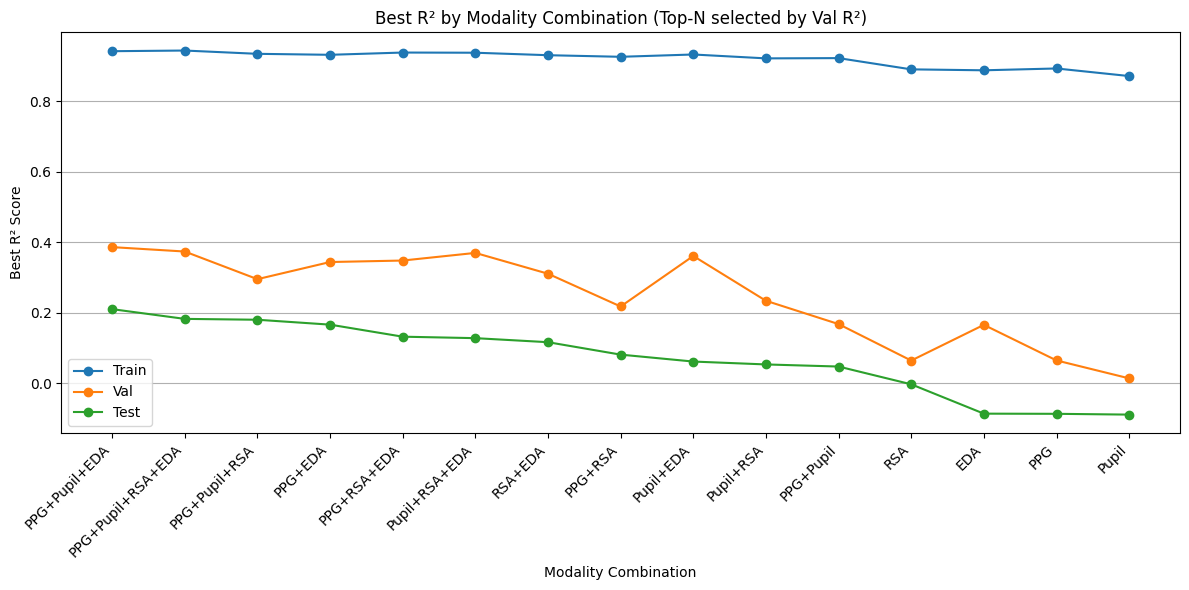

In [138]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ 제외할 키워드 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]

# ✅ 유효한 feature 컬럼 추출
valid_feature_cols = [
    col for col in window_df_all.columns
    if (
        col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time'] and
        all(ex_key not in col for ex_key in exclude_keywords) and
        window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
    )
]

# ✅ modality 정의
modality_features = {
    "PPG": [col for col in valid_feature_cols if col.startswith("PPG_")],
    "Pupil": [col for col in valid_feature_cols if col.startswith("pupil")],
    "RSA": [col for col in valid_feature_cols if col.startswith("RSP_")],
    "EDA": [col for col in valid_feature_cols if col.startswith("EDA_") or col.startswith("SCR_")]
}

# ✅ 조합 생성
modality_list = list(modality_features.keys())
all_combinations = []
for r in range(1, len(modality_list) + 1):
    all_combinations.extend(itertools.combinations(modality_list, r))

# ✅ 결과 저장용
performance_records = []

# ✅ 참여자별 split 적용 후 전체 결합
split_dfs = {"Train": [], "Val": [], "Test": []}

for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")

    if len(df_pid) <= 2:
        continue  # 60초 (2 window) 미만이면 제외 불가

    df_pid_trimmed = df_pid.iloc[:-2]  # 후반 60초 제외

    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val

    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

# ✅ 결합
df_splits = {
    k: pd.concat(v, axis=0).reset_index(drop=True)
    for k, v in split_dfs.items()
}

# ✅ 조합별 루프
for combo in all_combinations:
    combo_name = "+".join(combo)
    selected_features = []
    for modality in combo:
        selected_features.extend(modality_features[modality])
    selected_features = [f for f in selected_features if f in window_df_all.columns]

    X_train = df_splits["Train"][selected_features]
    y_train = df_splits["Train"]["anxiety_mean"]
    X_val = df_splits["Val"][selected_features]
    y_val = df_splits["Val"]["anxiety_mean"]
    X_test = df_splits["Test"][selected_features]
    y_test = df_splits["Test"]["anxiety_mean"]

    # ✅ feature importance 정렬
    model_full = RandomForestRegressor(random_state=42)
    model_full.fit(X_train, y_train)
    importances = model_full.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = [selected_features[i] for i in sorted_idx]

    # ✅ Validation R² 기준 best top-N feature 선택
    best_val_r2 = -np.inf
    best_n = None
    best_features = None
    for top_n in range(3, len(sorted_features) + 1):
        top_features = sorted_features[:top_n]
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train[top_features], y_train)
        val_pred = model.predict(X_val[top_features])
        val_r2 = r2_score(y_val, val_pred)
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            best_n = top_n
            best_features = top_features

    # ✅ 최종 평가
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train[best_features], y_train)
    for split_name, X_, y_ in zip(["Train", "Val", "Test"],
                                  [X_train, X_val, X_test],
                                  [y_train, y_val, y_test]):
        y_pred = model.predict(X_[best_features])
        r2 = r2_score(y_, y_pred)
        mae = mean_absolute_error(y_, y_pred)
        rmse = np.sqrt(mean_squared_error(y_, y_pred))
        performance_records.append({
            "Modality": combo_name,
            "TopN": best_n,
            "Split": split_name,
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse
        })

# ✅ 결과 시각화
perf_df = pd.DataFrame(performance_records)

# 정렬: Test R² 기준 내림차순
best_by_split = (
    perf_df.sort_values(["Modality", "Split", "R2"], ascending=[True, True, False])
    .drop_duplicates(subset=["Modality", "Split"], keep="first")
)
pivot_df = best_by_split.pivot(index="Modality", columns="Split", values="R2")
pivot_df = pivot_df.sort_values(by="Test", ascending=False)

plt.figure(figsize=(12, 6))
for split in ["Train", "Val", "Test"]:
    if split in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[split], marker='o', label=split)

plt.xticks(rotation=45, ha='right')
plt.xlabel("Modality Combination")
plt.ylabel("Best R² Score")
plt.title("Best R² by Modality Combination (Top-N selected by Val R²)")
plt.grid(True, axis="y")
plt.legend()
plt.tight_layout()
plt.savefig("best_r2_by_modality_valbased_sorted.png")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

def plot_prediction_trend(y_true, y_pred, modality_name=""):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, s=40, label='Predicted vs True')

    # 추세선 (선형 회귀)
    model = LinearRegression()
    y_true_reshaped = np.array(y_true).reshape(-1, 1)
    model.fit(y_true_reshaped, y_pred)
    trend = model.predict(y_true_reshaped)
    plt.plot(y_true, trend, color='red', linestyle='--', label='Trend Line')

    # 대각선 (완벽 예측 기준선)
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle=':', label='Perfect Prediction')

    plt.xlabel("True Anxiety")
    plt.ylabel("Predicted Anxiety")
    plt.title(f"Prediction vs True: {modality_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


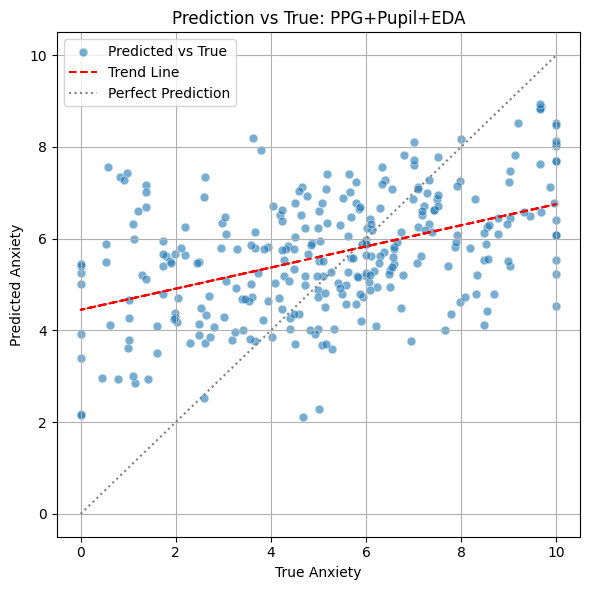

In [143]:
plot_prediction_trend(y_test, y_pred, modality_name="PPG+Pupil+EDA")

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Correlation 기반 feature 선택
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: col.corr(y))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features]

# 시각화: 선택된 feature의 상관관계 히트맵
def plot_correlation_heatmap(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation among Selected Features")
    plt.tight_layout()
    plt.show()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduce_features_by_pca(X, n_components=5):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    return pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# 시각화: 첫 두 PCA 컴포넌트
def plot_pca_scatter(X_pca, y):
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca['PC1'], X_pca['PC2'], c=y, cmap='viridis', s=30, alpha=0.7)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA - First Two Components")
    plt.colorbar(label='Anxiety')
    plt.tight_layout()
    plt.show()

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def select_features_rfecv(X, y, step=1, min_features_to_select=5):
    estimator = RandomForestRegressor(random_state=42)
    rfecv = RFECV(
        estimator=estimator,
        step=step,
        min_features_to_select=min_features_to_select,
        cv=KFold(5),
        scoring='r2',
        n_jobs=-1,
    )
    rfecv.fit(X, y)
    
    # 선택된 feature만 반환
    selected_features = X.columns[rfecv.support_]
    X_selected = X[selected_features]
    
    # 시각화: cross-validation score vs. number of features
    plt.figure(figsize=(6, 4))
    plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select), rfecv.grid_scores_)
    plt.xlabel("Number of Selected Features")
    plt.ylabel("Cross-Validation R² Score")
    plt.title("RFECV Feature Selection")
    plt.tight_layout()
    plt.show()
    
    print(f"Selected {len(selected_features)} features: {list(selected_features)}")
    return X_selected


def train_and_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    # 시각화: 예측 vs 실제
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel("Actual Anxiety")
    plt.ylabel("Predicted Anxiety")
    plt.title(f"Prediction Result (R² = {r2:.2f})")
    plt.tight_layout()
    plt.show()
    
    return r2


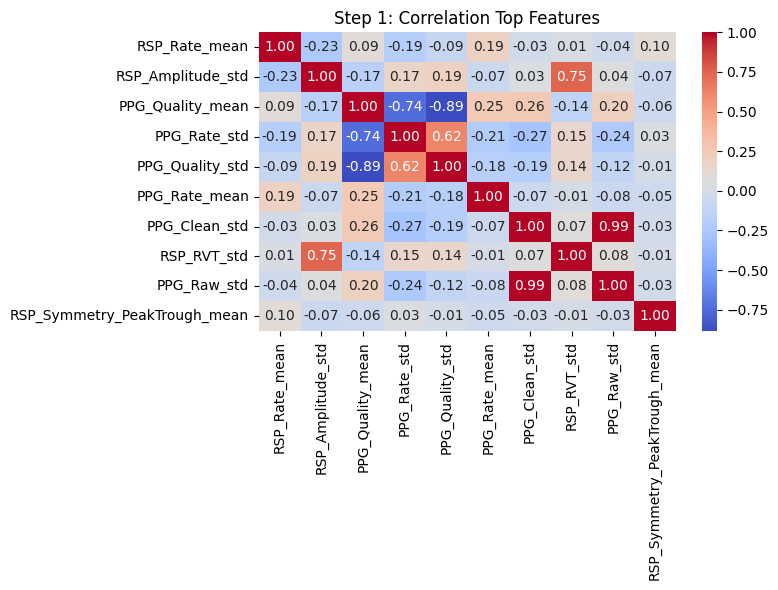

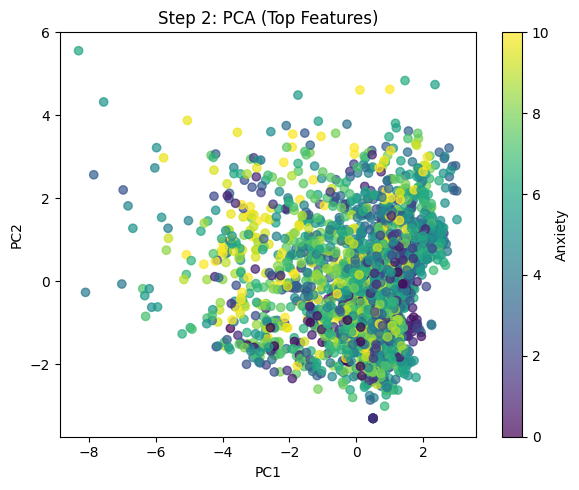

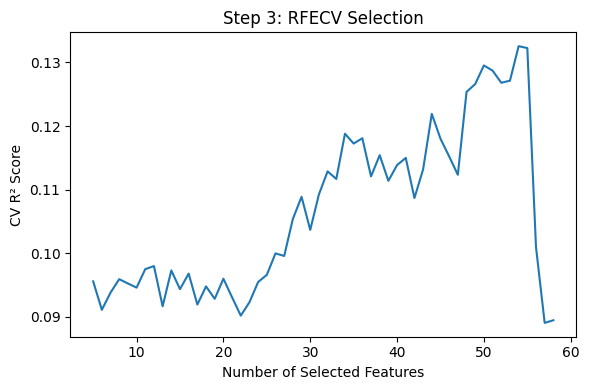

📊 R² Score Comparison
Step 1 (Top-Corr):   R² = 0.290
Step 2 (PCA):        R² = 0.184
Step 3 (RFECV):      R² = 0.551

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['pupilL_mean', 'pupilR_std', 'PPG_Clean_std', 'PPG_Rate_mean', 'PPG_Quality_mean', 'EDA_Raw_mean', 'EDA_Tonic_mean', 'RSP_Raw_mean', 'RSP_Raw_std']


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_87636\2154084311.py:117: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_87636\2154084311.py:117: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


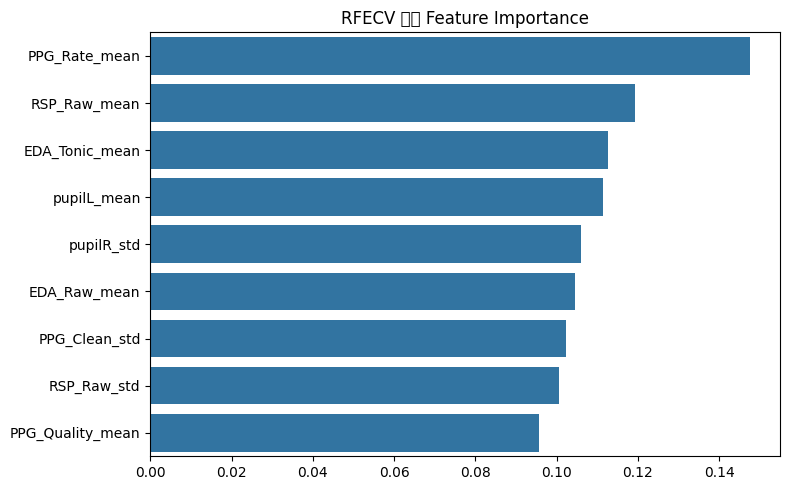

In [13]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

model = RandomForestRegressor(random_state=42)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(rfecv.n_features_in_, rfecv.n_features_in_ - len(rfecv.cv_results_["mean_test_score"]), -1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")
print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)
print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))

final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_rfecv, y_full)
importances = final_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_features = [selected_rfecv_features[i] for i in sorted_idx]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[sorted_idx], y=sorted_features)
plt.title("RFECV 최종 Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
# 중요도 상위 20개 feature만 추출
top_n = 12
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
top20_features = [feature_cols[i] for i in indices[:top_n]]

# X 재정의
X = window_df_all[top20_features]
y = window_df_all['anxiety_mean']

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 모델 학습
from sklearn.ensemble import RandomForestRegressor
model_top = RandomForestRegressor(random_state=42)
model_top.fit(X_train, y_train)

# 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_pred = model_top.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


MAE: 1.272, RMSE: 1.630, R²: 0.603


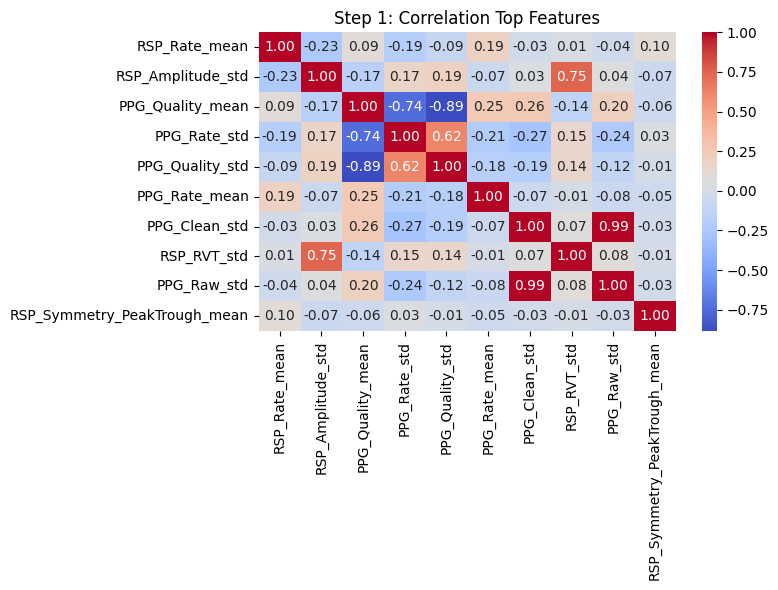

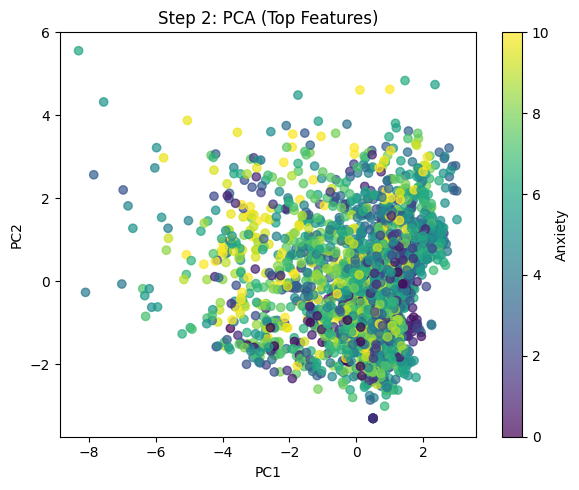

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.p

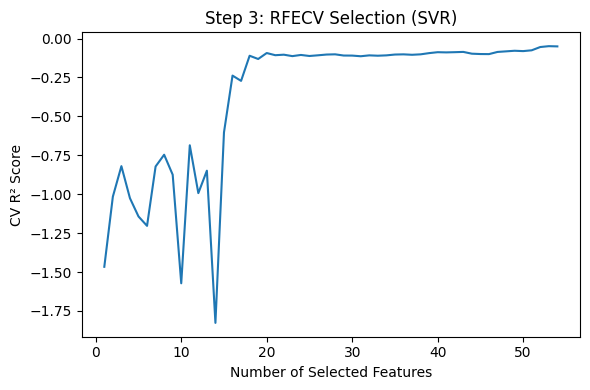

📊 R² Score Comparison (SVR)
Step 1 (Top-Corr):   R² = -0.327
Step 2 (PCA):        R² = 0.011
Step 3 (RFECV):      R² = -0.007

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['PPG_Clean_std', 'PPG_Quality_std', 'RSP_Clean_std', 'RSP_RVT_mean', 'RSP_Phase_std', 'RSP_Symmetry_RiseDecay_std']


c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ✅ Step 0: 유효 feature 정의
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

# ✅ Step 0.5: participant별 split 적용
split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ✅ Step 1: Correlation 기반 Top-N Feature
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ✅ Step 2: PCA (Top-N Correlation Feature 기반)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ✅ Step 3: RFECV Wrapper Feature Selection (전체 feature 대상)
model = LinearSVR()
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(len(rfecv.cv_results_["mean_test_score"]), 0, -1), rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection (SVR)")
plt.tight_layout()
plt.show()

# ✅ 평가 함수
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearSVR()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ✅ R² Score 비교
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (SVR)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")
print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)
print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))


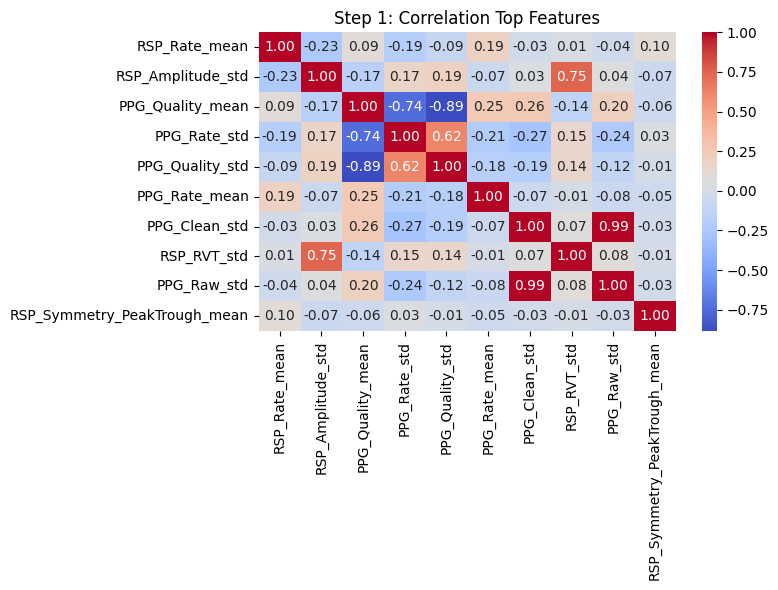

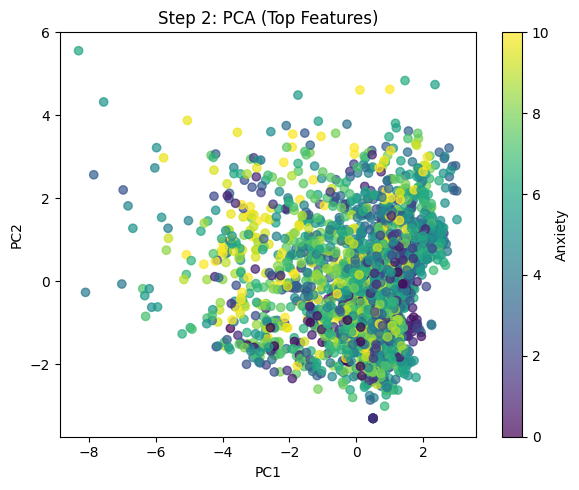

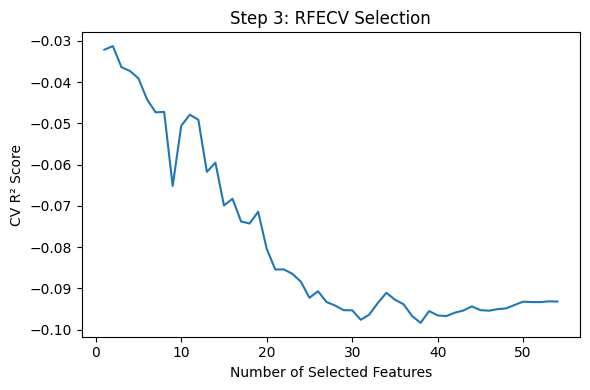

📊 R² Score Comparison (Ridge)
Step 1 (Top-Corr):   R² = 0.029
Step 2 (PCA):        R² = 0.027
Step 3 (RFECV):      R² = 0.019

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['PPG_Raw_std', 'PPG_Clean_std', 'EDA_Raw_std', 'EDA_Clean_std', 'RSP_Clean_std', 'RSP_RVT_mean']


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
# 전처리된 DataFrame(window_df_all)과 anxiety_mean 컬럼이 있다고 가정
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: Correlation 기반 선택 ----------
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ---------- Step 2: PCA ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ---------- Step 3: RFECV ----------
model = Ridge()
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

# ---------- 모델 훈련 함수 ----------
def train_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = Ridge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ---------- 모델 평가 ----------
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (Ridge)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")

print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)

print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))


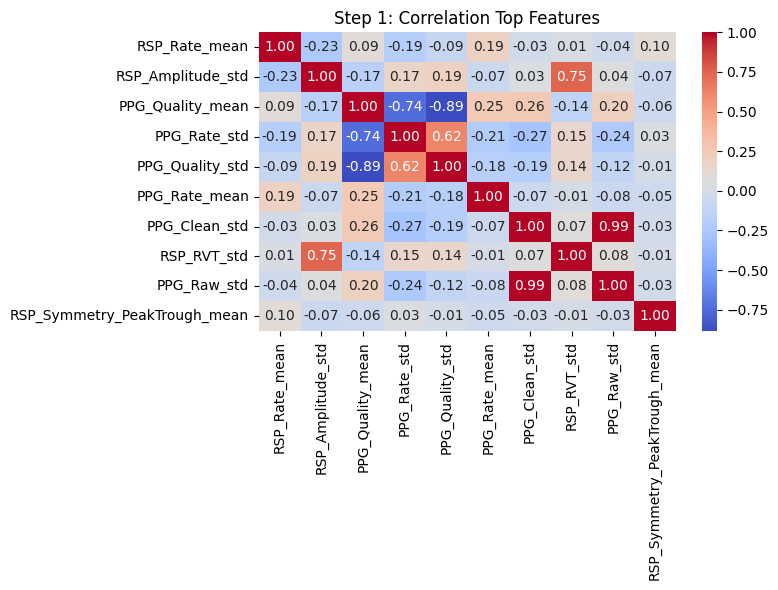

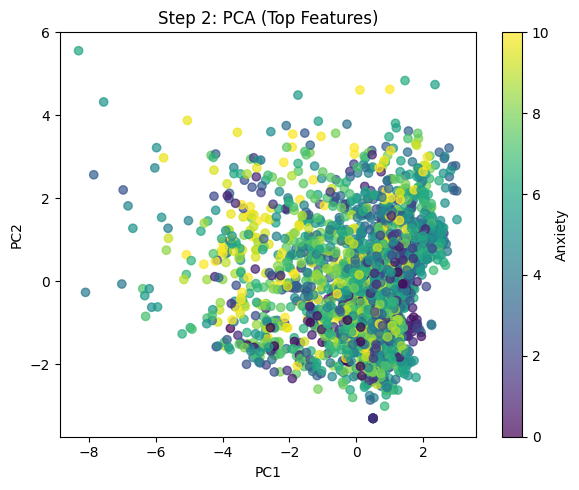

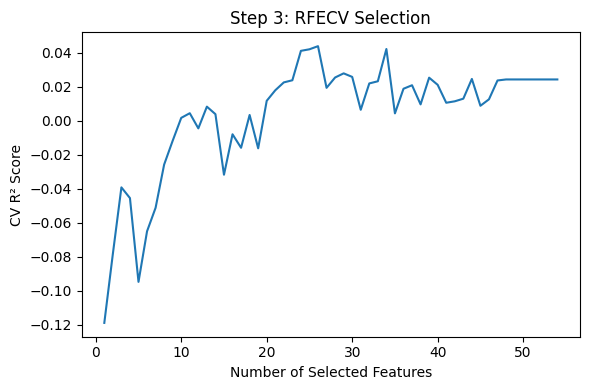

📊 R² Score Comparison (XGBoost)
Step 1 (Top-Corr):   R² = 0.201
Step 2 (PCA):        R² = 0.043
Step 3 (RFECV):      R² = 0.508

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['pupilR_mean', 'pupilR_std', 'PPG_Raw_std', 'PPG_Clean_std', 'PPG_Rate_mean', 'PPG_Rate_std', 'PPG_Quality_mean', 'PPG_Quality_std', 'EDA_Raw_mean', 'EDA_Clean_mean', 'EDA_Tonic_mean', 'EDA_Tonic_std', 'EDA_Phasic_std', 'SCR_Amplitude_mean', 'SCR_RiseTime_mean', 'SCR_Recovery_mean', 'SCR_RecoveryTime_mean', 'RSP_Raw_mean', 'RSP_Raw_std', 'RSP_Clean_std', 'RSP_Amplitude_mean', 'RSP_Amplitude_std', 'RSP_Rate_mean', 'RSP_Rate_std', 'RSP_RVT_mean', 'RSP_RVT_std', 'RSP_Symmetry_PeakTrough_mean', 'RSP_Symmetry_PeakTrough_std', 'RSP_Symmetry_RiseDecay_mean', 'RSP_Symmetry_RiseDecay_std']


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: Correlation 기반 선택 ----------
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ---------- Step 2: PCA ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ---------- Step 3: RFECV ----------
model = XGBRegressor(random_state=42, n_jobs=-1)
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

# ---------- 모델 훈련 함수 ----------
def train_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = XGBRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ---------- 모델 평가 ----------
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (XGBoost)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")

print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)

print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))


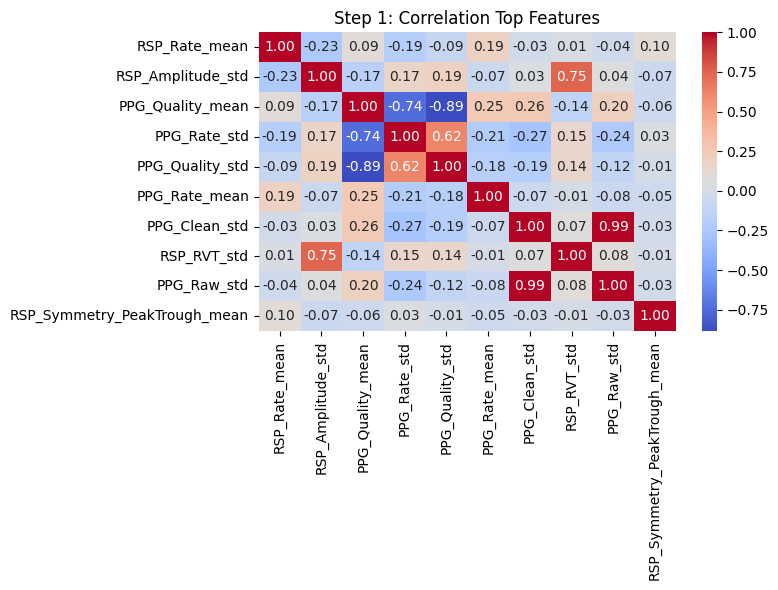

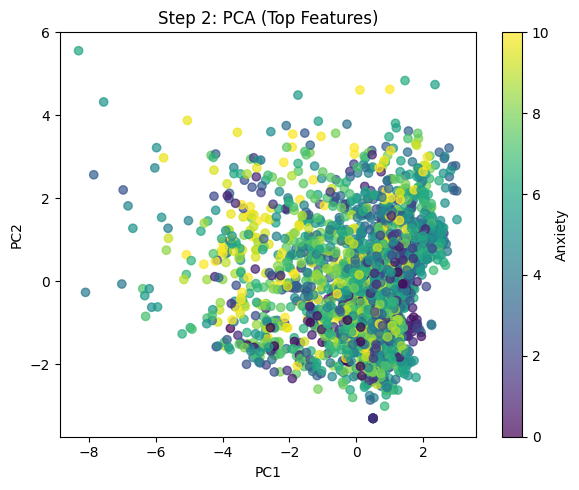

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10196
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 58
[LightGBM] [Info] Start training from score 5.520153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10192
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 57
[LightGBM] [Info] Start training from score 5.520153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 56
[LightGBM] [Info] Start tra

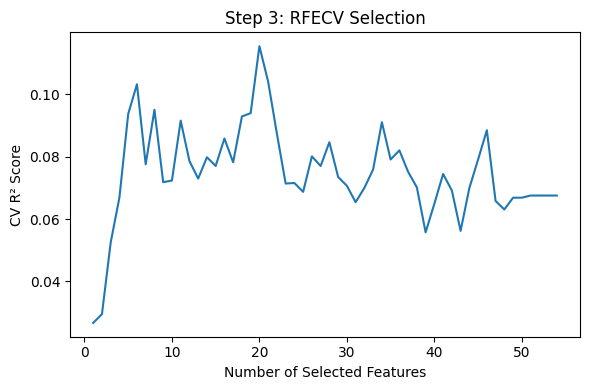

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 10
[LightGBM] [Info] Start training from score 5.505321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 5
[LightGBM] [Info] Start training from score 5.505321
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 24
[LightGBM] [Info] Start trainin

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: Correlation 기반 선택 ----------
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ---------- Step 2: PCA ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ---------- Step 3: RFECV ----------
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
model = lgb.LGBMRegressor(random_state=42)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

# ---------- 모델 훈련 함수 ----------
def train_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ---------- 모델 평가 ----------
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (LightGBM)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")

print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)

print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))


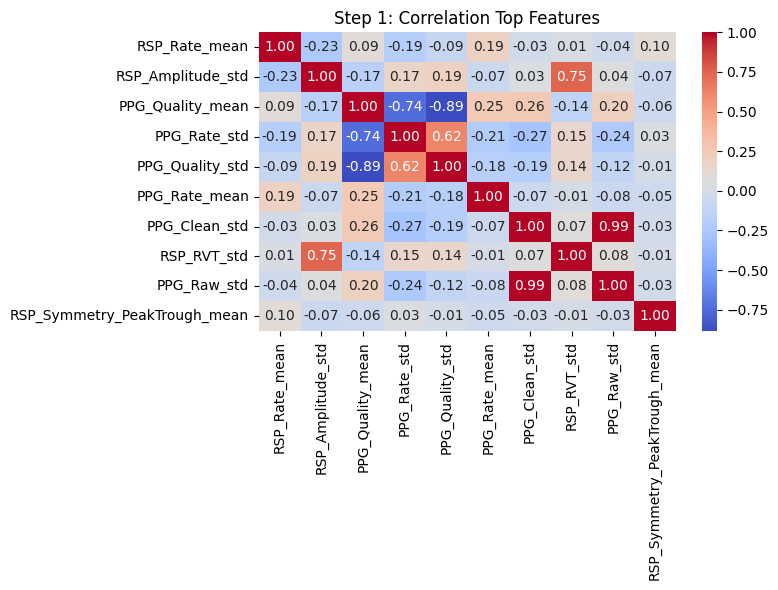

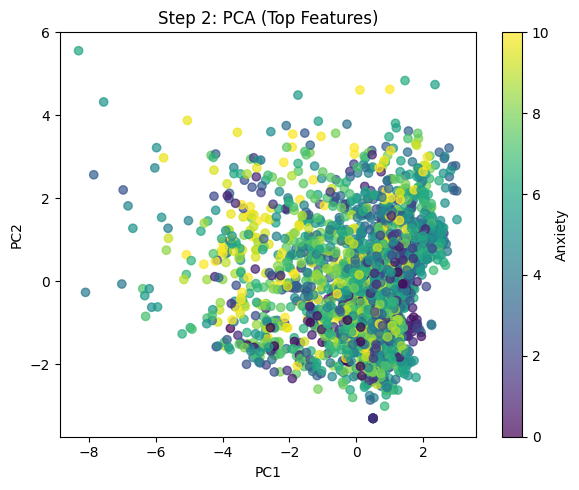

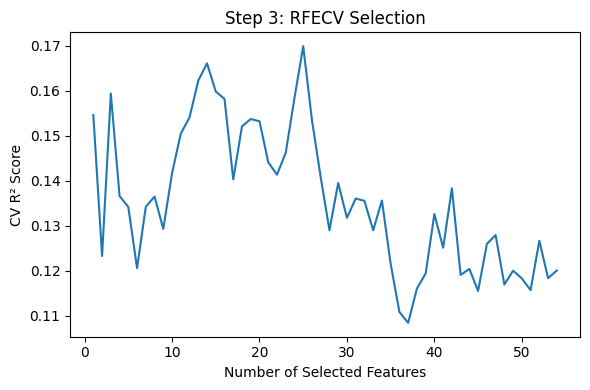

📊 R² Score Comparison (CatBoost)
Step 1 (Top-Corr):   R² = 0.307
Step 2 (PCA):        R² = 0.183
Step 3 (RFECV):      R² = 0.611

✅ Step 1 최종 선택 Feature:
['RSP_Rate_mean', 'RSP_Amplitude_std', 'PPG_Quality_mean', 'PPG_Rate_std', 'PPG_Quality_std', 'PPG_Rate_mean', 'PPG_Clean_std', 'RSP_RVT_std', 'PPG_Raw_std', 'RSP_Symmetry_PeakTrough_mean']

✅ Step 3 RFECV 최종 선택 Feature:
['pupilL_mean', 'pupilL_std', 'pupilR_mean', 'pupilR_std', 'PPG_Raw_std', 'PPG_Clean_std', 'PPG_Rate_mean', 'PPG_Rate_std', 'PPG_Quality_mean', 'PPG_Quality_std', 'EDA_Raw_mean', 'EDA_Clean_mean', 'EDA_Clean_std', 'EDA_Tonic_mean', 'EDA_Tonic_std', 'EDA_Phasic_std', 'RSP_Raw_mean', 'RSP_Raw_std', 'RSP_Clean_std', 'RSP_Amplitude_mean', 'RSP_Amplitude_std', 'RSP_Rate_mean', 'RSP_Rate_std', 'RSP_RVT_mean', 'RSP_RVT_std', 'RSP_Symmetry_PeakTrough_mean', 'RSP_Symmetry_PeakTrough_std', 'RSP_Symmetry_RiseDecay_mean', 'RSP_Symmetry_RiseDecay_std']


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: Correlation 기반 선택 ----------
def select_top_correlated_features(X, y, top_n=10):
    corrs = X.apply(lambda col: pd.Series(col).corr(pd.Series(y)))
    top_features = corrs.abs().sort_values(ascending=False).head(top_n).index.tolist()
    return X[top_features], top_features, corrs[top_features]

X_corr, top_corr_features, corr_values = select_top_correlated_features(X_full, y_full, top_n=10)

plt.figure(figsize=(8, 6))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Step 1: Correlation Top Features")
plt.tight_layout()
plt.show()

# ---------- Step 2: PCA ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_corr)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])

plt.figure(figsize=(6, 5))
plt.scatter(X_pca_df["PC1"], X_pca_df["PC2"], c=y_full, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Step 2: PCA (Top Features)")
plt.colorbar(label="Anxiety")
plt.tight_layout()
plt.show()

# ---------- Step 3: RFECV ----------
model = CatBoostRegressor(verbose=0, random_state=42)
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of Selected Features")
plt.ylabel("CV R² Score")
plt.title("Step 3: RFECV Selection")
plt.tight_layout()
plt.show()

# ---------- 모델 훈련 함수 ----------
def train_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = CatBoostRegressor(verbose=0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

# ---------- 모델 평가 ----------
r2_corr = train_model(X_corr, y_full)
r2_pca = train_model(X_pca_df, y_full)
r2_rfecv = train_model(X_rfecv, y_full)

print("📊 R² Score Comparison (CatBoost)")
print(f"Step 1 (Top-Corr):   R² = {r2_corr:.3f}")
print(f"Step 2 (PCA):        R² = {r2_pca:.3f}")
print(f"Step 3 (RFECV):      R² = {r2_rfecv:.3f}")

print("\n✅ Step 1 최종 선택 Feature:")
print(top_corr_features)

print("\n✅ Step 3 RFECV 최종 선택 Feature:")
print(list(selected_rfecv_features))



📊 Baseline (Default CatBoost) Results:
R²    = 0.596
RMSE  = 1.584
MAE   = 1.224
Fitting 5 folds for each of 12 candidates, totalling 60 fits

🏆 Grid Search Best Model Results:
R²    = 0.600
RMSE  = 1.577
MAE   = 1.191

✅ Best Params: {'model__depth': 8, 'model__l2_leaf_reg': 3, 'model__learning_rate': 0.1}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1568550938.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")


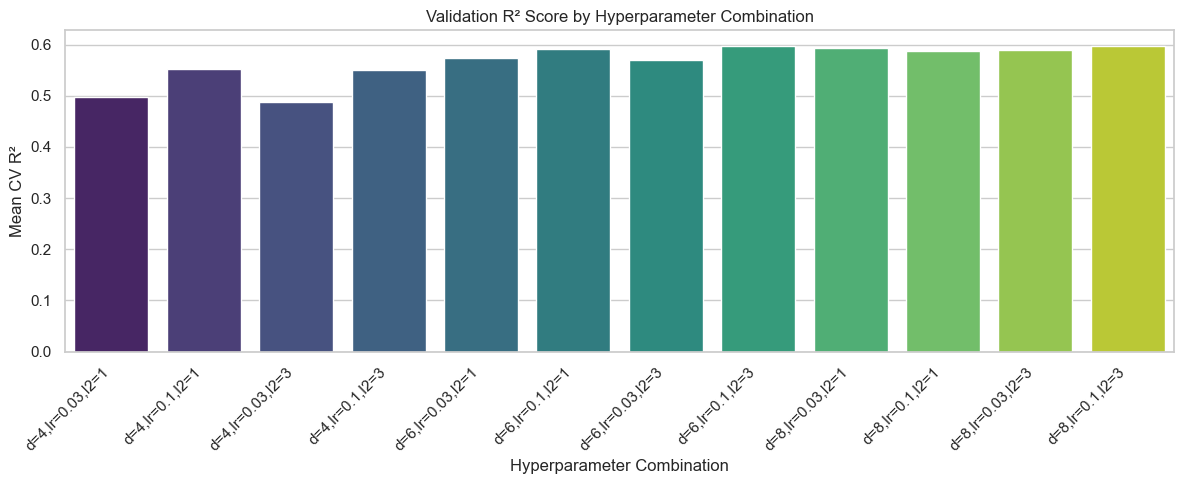

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = CatBoostRegressor(verbose=0, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)


# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default CatBoost) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")  # ← 수정됨
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.03, 0.1],
    'model__l2_leaf_reg': [1, 3]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', CatBoostRegressor(verbose=0, random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")  # ✅ 수정됨
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__depth']},lr={row['param_model__learning_rate']},l2={row['param_model__l2_leaf_reg']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()



📊 Baseline (Default Random Forest) Results:
R²    = 0.543
RMSE  = 1.685
MAE   = 1.282
Fitting 5 folds for each of 48 candidates, totalling 240 fits

🏆 Grid Search Best Model Results:
R²    = 0.545
RMSE  = 1.681
MAE   = 1.296

✅ Best Params: {'model__max_depth': None, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\2580537870.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")


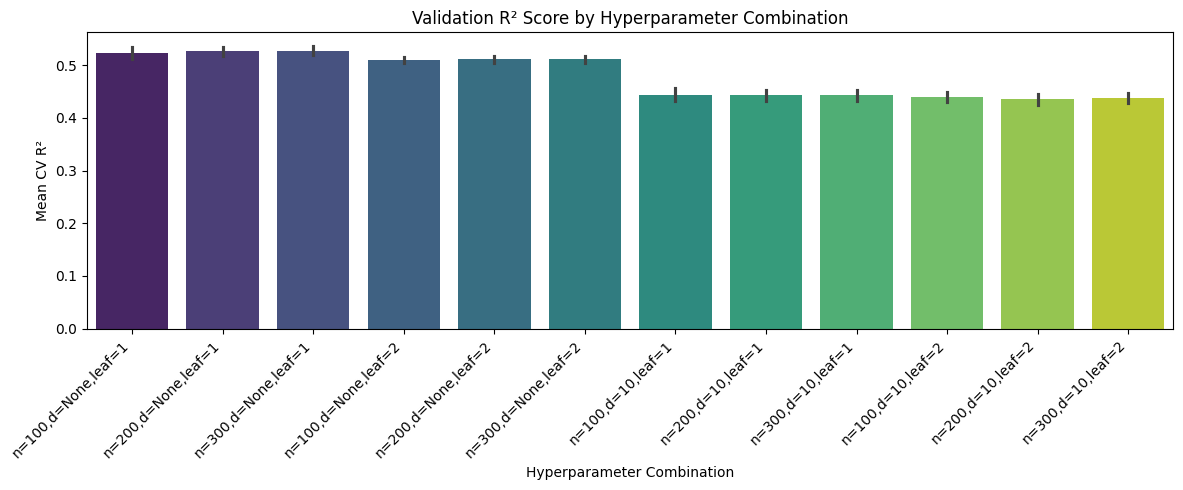

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = RandomForestRegressor(random_state=42, n_jobs=-1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

rfecv = RFECV(
    estimator=model,
    step=1,
    min_features_to_select=5,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
rfecv.fit(X_scaled, y_full)

selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default Random Forest) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10],
    'model__min_samples_leaf': [1, 2],
    'model__min_samples_split': [2, 5],
    'model__max_features': ['sqrt', 0.5]  # 'auto' 제거
}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"n={row['param_model__n_estimators']},d={row['param_model__max_depth']},leaf={row['param_model__min_samples_leaf']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()



📊 Baseline (Default XGBoost) Results:
R²    = 0.528
RMSE  = 1.713
MAE   = 1.324
Fitting 5 folds for each of 108 candidates, totalling 540 fits

🏆 Grid Search Best Model Results:
R²    = 0.548
RMSE  = 1.675
MAE   = 1.274

✅ Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 300, 'model__subsample': 0.6}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\3886733617.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")


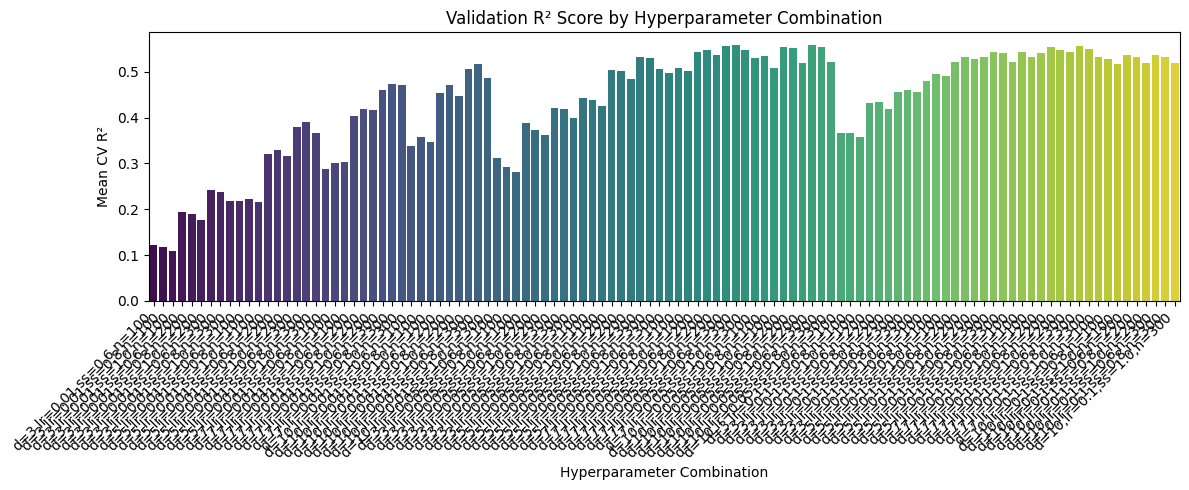

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = XGBRegressor(verbosity=0, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(verbosity=0, random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default XGBoost) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(verbosity=0, random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__max_depth']},lr={row['param_model__learning_rate']},ss={row['param_model__subsample']},n={row['param_model__n_estimators']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10196
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 58
[LightGBM] [Info] Start training from score 5.520153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10192
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 57
[LightGBM] [Info] Start training from score 5.520153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 2086, number of used features: 56
[LightGBM] [Info] Start tra

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



📊 Baseline (Default LightGBM) Results:
R²    = 0.504
RMSE  = 1.755
MAE   = 1.371
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 24
[LightGBM] [Info] Start training from score 5.505321


c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\3078718811.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")



🏆 Grid Search Best Model Results:
R²    = 0.561
RMSE  = 1.651
MAE   = 1.277

✅ Best Params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': -1, 'model__n_estimators': 300, 'model__num_leaves': 31, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1, 'model__subsample': 0.6}


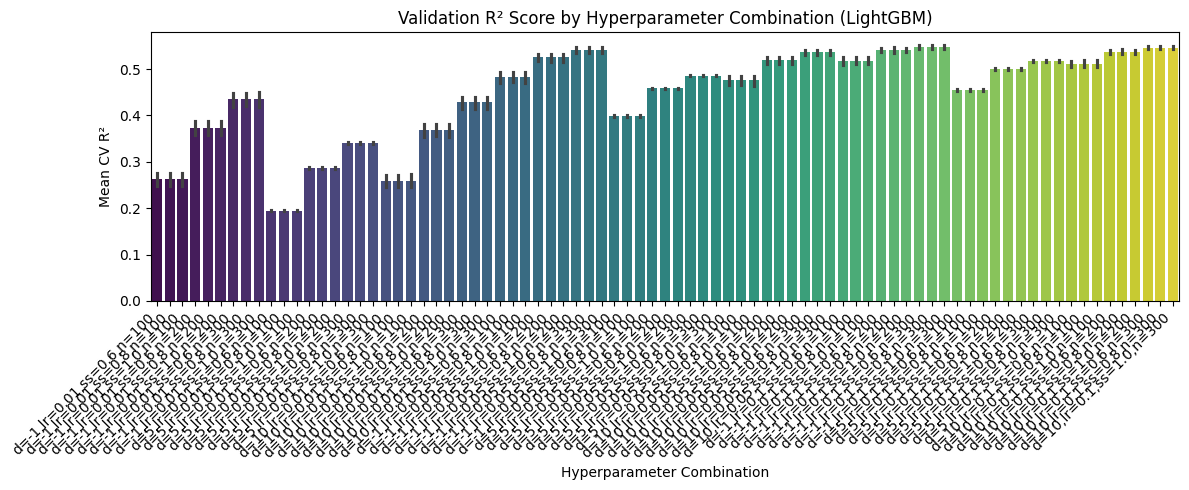

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = LGBMRegressor(random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default LightGBM) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [-1, 5, 10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__num_leaves': [15, 31, 63],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.1],
    'model__reg_lambda': [0, 0.1]
}


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMRegressor(random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__max_depth']},lr={row['param_model__learning_rate']},ss={row['param_model__subsample']},n={row['param_model__n_estimators']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination (LightGBM)")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()



📊 Baseline (Default GradientBoosting) Results:
R²    = 0.369
RMSE  = 1.980
MAE   = 1.568
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

🏆 Grid Search Best Model Results:
R²    = 0.570
RMSE  = 1.634
MAE   = 1.224

✅ Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300, 'model__subsample': 0.8}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\1043208582.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")


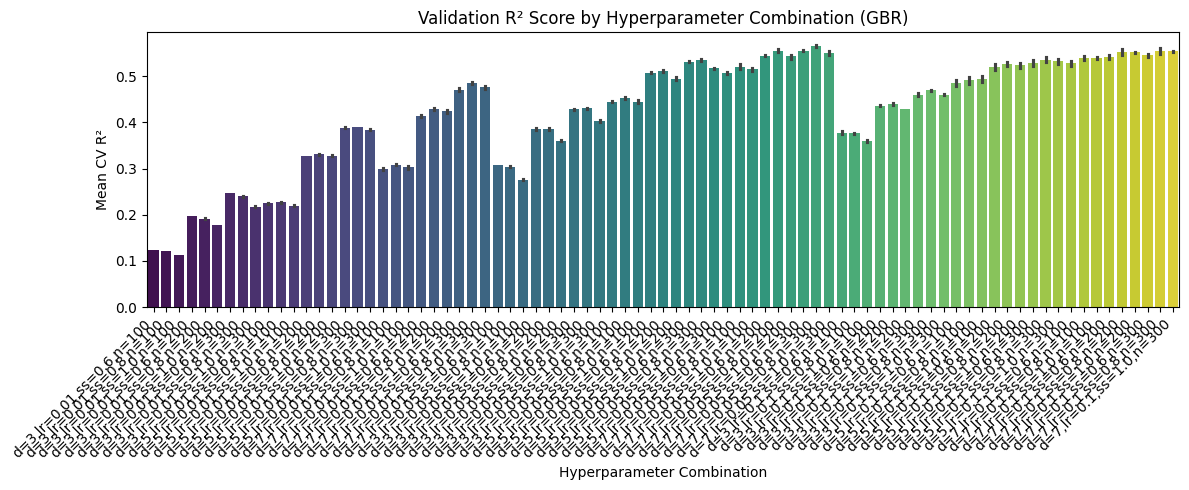

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = GradientBoostingRegressor(random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default GradientBoosting) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 3]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__max_depth']},lr={row['param_model__learning_rate']},ss={row['param_model__subsample']},n={row['param_model__n_estimators']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination (GBR)")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()



📊 Baseline (Default GradientBoosting) Results:
R²    = 0.369
RMSE  = 1.980
MAE   = 1.568
Fitting 5 folds for each of 81 candidates, totalling 405 fits

🏆 Grid Search Best Model Results:
R²    = 0.570
RMSE  = 1.634
MAE   = 1.224

✅ Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 0.8}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\399420489.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")


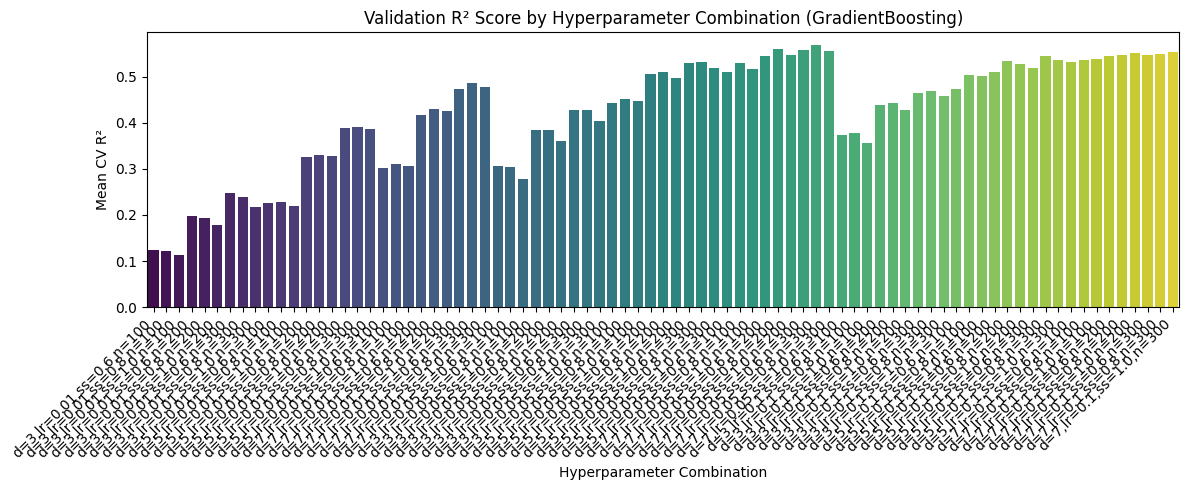

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = GradientBoostingRegressor(random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default GradientBoosting) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.6, 0.8, 1.0]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=42))
])

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"d={row['param_model__max_depth']},lr={row['param_model__learning_rate']},ss={row['param_model__subsample']},n={row['param_model__n_estimators']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination (GradientBoosting)")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Train/Test split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# ---------- SVR 파이프라인 + GridSearch ----------
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel='rbf'))
])

param_grid = {
    'model__C': [0.1, 1, 10, 100],
    'model__gamma': ['scale', 0.01, 0.1, 1],
    'model__epsilon': [0.1, 0.2, 0.3]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid.fit(X_trainval, y_trainval)

# ---------- 예측 및 평가 ----------
y_pred = grid.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("🏆 SVR (RBF Kernel) GridSearch Results:")
print(f"R²    = {r2:.3f}")
print(f"RMSE  = {rmse:.3f}")
print(f"MAE   = {mae:.3f}")
print("\n✅ Best Params:", grid.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
🏆 SVR (RBF Kernel) GridSearch Results:
R²    = 0.396
RMSE  = 1.936
MAE   = 1.480

✅ Best Params: {'model__C': 100, 'model__epsilon': 0.1, 'model__gamma': 0.1}



📊 Baseline (Default Ridge) Results:
R²    = 0.019
RMSE  = 2.468
MAE   = 2.028
Fitting 5 folds for each of 120 candidates, totalling 600 fits

🏆 Grid Search Best Model Results:
R²    = 0.106
RMSE  = 2.356
MAE   = 1.877

✅ Best Params: {'model__alpha': np.float64(0.01), 'model__degree': 2, 'model__gamma': np.float64(0.1), 'model__kernel': 'rbf'}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\1116147929.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="coolwarm")


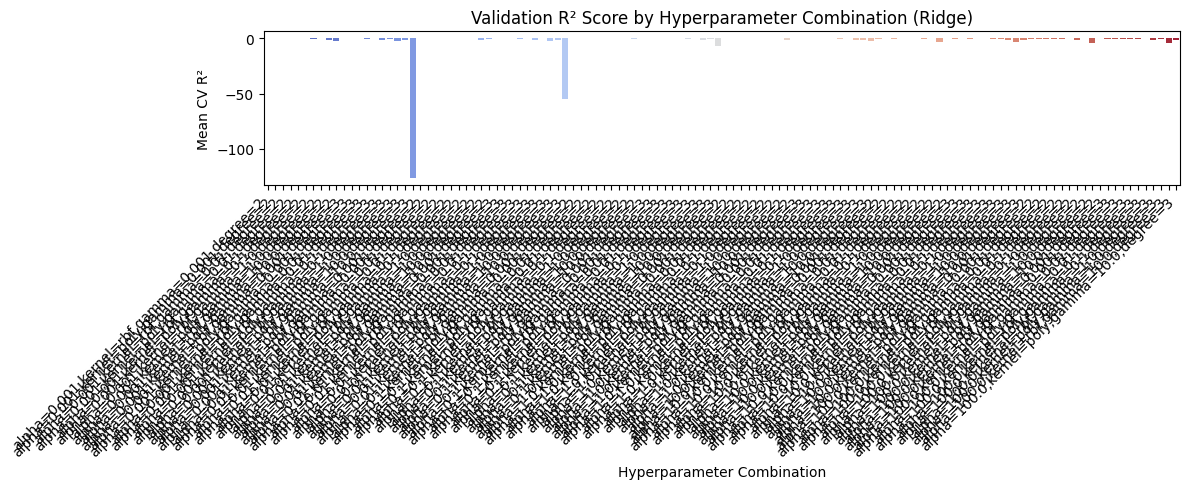

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 1: RFECV ----------
model = Ridge()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
rfecv = RFECV(estimator=model, step=1, min_features_to_select=5, cv=5, scoring='r2', n_jobs=-1)
rfecv.fit(X_scaled, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_rfecv, y_full, test_size=0.2, random_state=42)

# ---------- Baseline 모델 ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default Ridge) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
from sklearn.kernel_ridge import KernelRidge

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KernelRidge())
])

param_grid = {
    'model__alpha': np.logspace(-3, 2, 6),
    'model__kernel': ['rbf', 'poly'],
    'model__gamma': np.logspace(-3, 1, 5),  # rbf 전용
    'model__degree': [2, 3]  # poly 전용
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best Model Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"alpha={row['param_model__alpha']},kernel={row['param_model__kernel']},gamma={row.get('param_model__gamma', 'NA')},degree={row.get('param_model__degree', 'NA')}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination (Ridge)")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()



📊 Baseline (Default MLP) Results:
R²    = 0.016
RMSE  = 2.472
MAE   = 1.754
Fitting 5 folds for each of 48 candidates, totalling 240 fits

🏆 Grid Search Best MLP Results:
R²    = 0.048
RMSE  = 2.431
MAE   = 1.846

✅ Best Params: {'model__activation': 'tanh', 'model__alpha': 0.01, 'model__hidden_layer_sizes': (100,), 'model__learning_rate': 'constant'}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\3260906329.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="coolwarm")


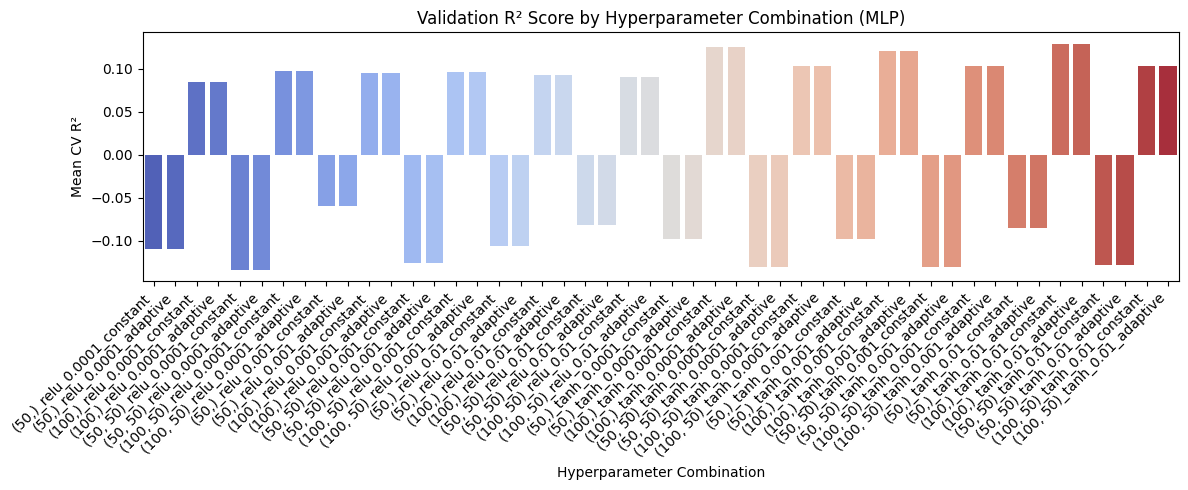

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# ---------- Baseline MLP ----------
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(random_state=42, max_iter=1000))
])
baseline_model.fit(X_trainval, y_trainval)
baseline_pred = baseline_model.predict(X_test)

print("\n📊 Baseline (Default MLP) Results:")
print(f"R²    = {r2_score(y_test, baseline_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, baseline_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, baseline_pred):.3f}")

# ---------- GridSearchCV ----------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(random_state=42, max_iter=1000))
])

param_grid = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [1e-4, 1e-3, 1e-2],
    'model__learning_rate': ['constant', 'adaptive']
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)
grid.fit(X_trainval, y_trainval)

# ---------- 최적 모델 테스트 ----------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("\n🏆 Grid Search Best MLP Results:")
print(f"R²    = {r2_score(y_test, y_pred):.3f}")
print(f"RMSE  = {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")
print(f"MAE   = {mean_absolute_error(y_test, y_pred):.3f}")
print(f"\n✅ Best Params: {grid.best_params_}")

# ---------- GridSearchCV 결과 시각화 ----------
cv_results = pd.DataFrame(grid.cv_results_)
cv_results['param_combo'] = cv_results.apply(
    lambda row: f"{row['param_model__hidden_layer_sizes']}_{row['param_model__activation']}_{row['param_model__alpha']}_{row['param_model__learning_rate']}",
    axis=1
)

plt.figure(figsize=(12, 5))
sns.barplot(data=cv_results, x="param_combo", y="mean_test_score", palette="coolwarm")
plt.xticks(rotation=45, ha='right')
plt.title("Validation R² Score by Hyperparameter Combination (MLP)")
plt.ylabel("Mean CV R²")
plt.xlabel("Hyperparameter Combination")
plt.tight_layout()
plt.show()



🔍 Running: Lasso
Fitting 5 folds for each of 6 candidates, totalling 30 fits

🏆 Lasso Results:
R²    = 0.051
RMSE  = 2.428
MAE   = 2.006

✅ Best Params: {'model__alpha': np.float64(0.01)}

🔍 Running: LightGBM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10131
[LightGBM] [Info] Number of data points in the train set: 1668, number of used features: 58
[LightGBM] [Info] Start training from score 5.505321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



🏆 KNN Results:
R²    = 0.388
RMSE  = 1.949
MAE   = 1.377

✅ Best Params: {'model__n_neighbors': 3, 'model__weights': 'distance'}


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\3474748873.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="R2", palette="Set2")


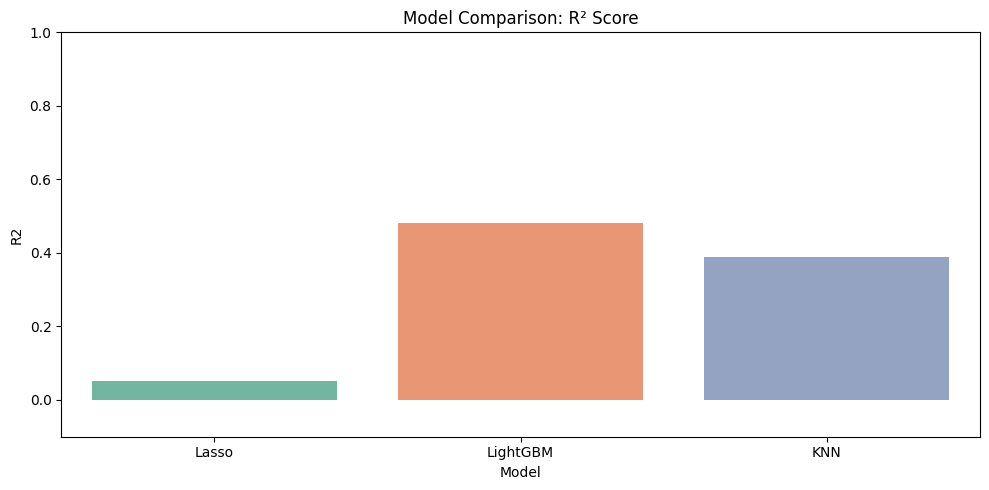

C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\3474748873.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="RMSE", palette="Set2")


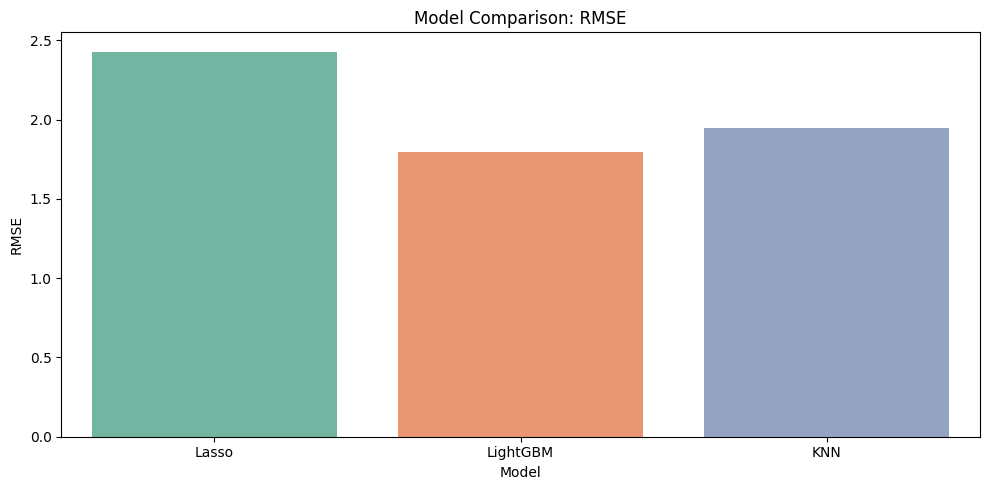

C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_20112\3474748873.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="MAE", palette="Set2")


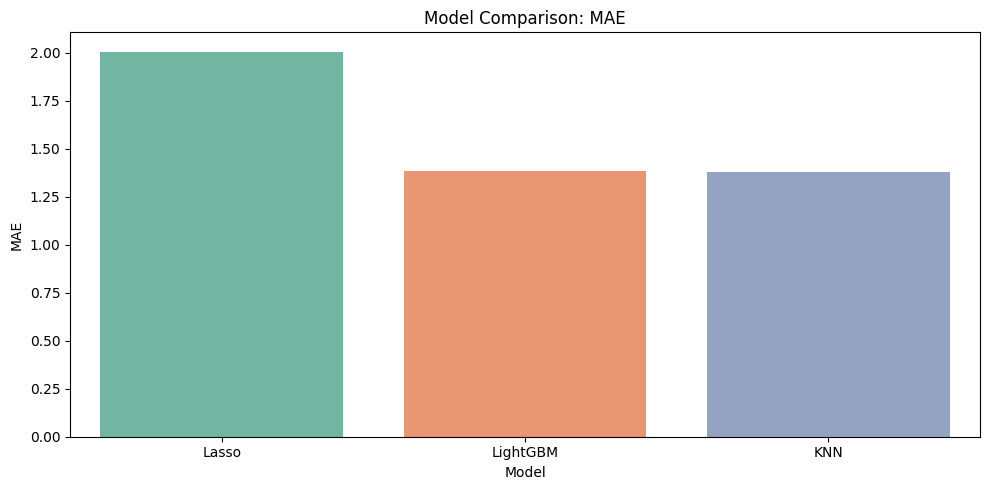

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Train/Test Split ----------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# ---------- 공통 실행 함수 ----------
results = []

def run_model(name, estimator, param_grid):
    print(f"\n🔍 Running: {name}")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', estimator)
    ])
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        verbose=2,
        n_jobs=-1
    )
    grid.fit(X_trainval, y_trainval)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n🏆 {name} Results:")
    print(f"R²    = {r2:.3f}")
    print(f"RMSE  = {rmse:.3f}")
    print(f"MAE   = {mae:.3f}")
    print(f"\n✅ Best Params: {grid.best_params_}")

    results.append({
        'Model': name,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Best Params': grid.best_params_
    })

# ---------- 1. Lasso ----------
run_model(
    "Lasso",
    Lasso(max_iter=5000),
    {'model__alpha': np.logspace(-4, 1, 6)}
)

# ---------- 2. LightGBM ----------
run_model(
    "LightGBM",
    LGBMRegressor(random_state=42),
    {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5, 7]
    }
)

# ---------- 3. KNN ----------
run_model(
    "KNN",
    KNeighborsRegressor(),
    {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    }
)

# ---------- 결과 시각화 ----------
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="R2", palette="Set2")
plt.title("Model Comparison: R² Score")
plt.ylim(-0.1, 1.0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="RMSE", palette="Set2")
plt.title("Model Comparison: RMSE")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Model", y="MAE", palette="Set2")
plt.title("Model Comparison: MAE")
plt.tight_layout()
plt.show()


In [29]:
results_df

Model        R2      RMSE       MAE  \
0     Lasso  0.050731  2.428338  2.005890   
1  LightGBM  0.482683  1.792638  1.385703   
2       KNN  0.388325  1.949282  1.377389   

                                         Best Params  
0                             {'model__alpha': 0.01}  
1  {'model__learning_rate': 0.1, 'model__max_dept...  
2  {'model__n_neighbors': 3, 'model__weights': 'd...

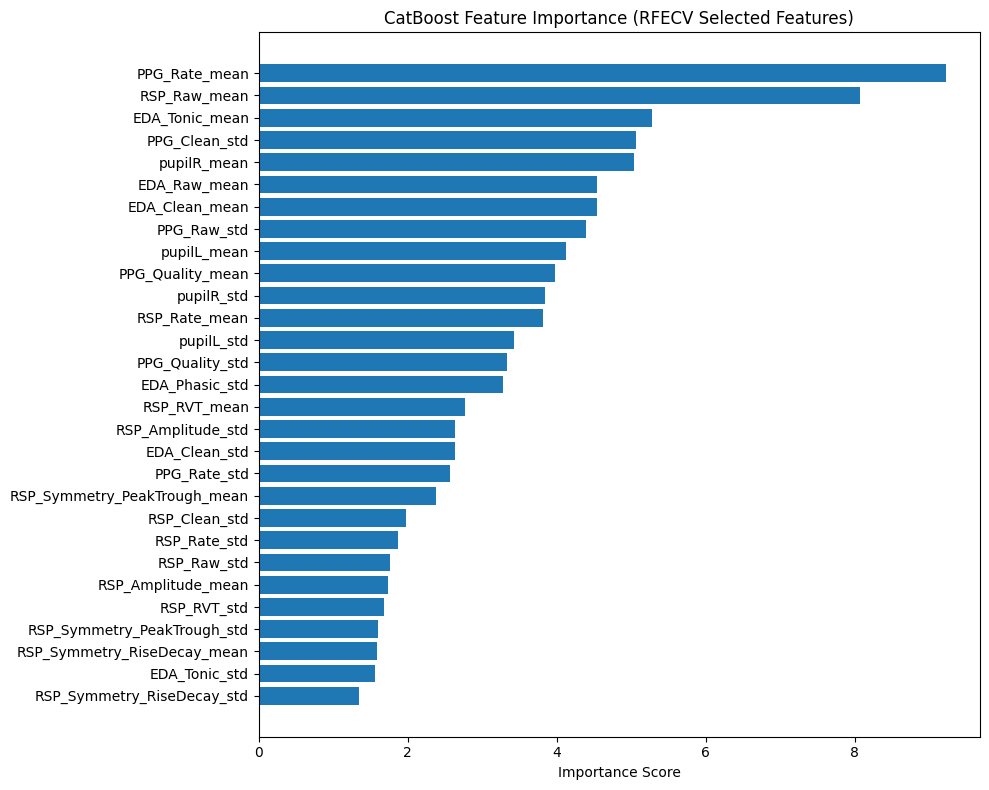

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool

# --- Step 3에서 선택된 Feature 사용 ---
X_selected = X_full[selected_rfecv_features]
y_selected = y_full

# --- 모델 학습 ---
model_cb = CatBoostRegressor(verbose=0)
model_cb.fit(X_selected, y_selected)

# --- Feature Importance 추출 ---
feature_importances = model_cb.get_feature_importance()
feature_names = selected_rfecv_features

# --- DataFrame으로 정리 ---
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# --- 시각화 ---
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.title('CatBoost Feature Importance (RFECV Selected Features)')
plt.tight_layout()
plt.show()


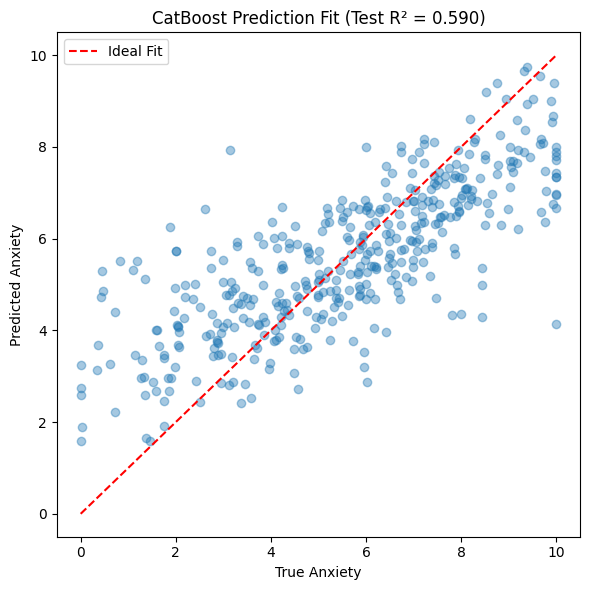

In [29]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# --- 데이터 분리 ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfecv)  # 선택된 feature 사용
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_full, test_size=0.2, random_state=42)

# --- 모델 학습 ---
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)

# --- 예측 및 시각화 ---
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
plt.xlabel("True Anxiety")
plt.ylabel("Predicted Anxiety")
plt.title(f"CatBoost Prediction Fit (Test R² = {r2:.3f})")
plt.legend()
plt.tight_layout()
plt.show()


📊 MLP Regressor R² Score
Train: 0.356
Test:  0.104


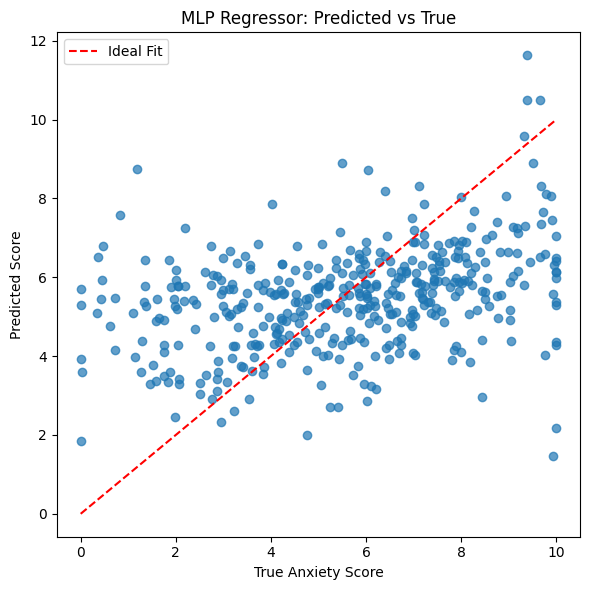

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

# ---------- 데이터 준비 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

split_dfs = {"Train": [], "Val": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.8)
    n_val = int(n_total * 0.1)
    n_test = n_total - n_train - n_val
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Val"].append(df_pid_trimmed.iloc[n_train:n_train + n_val])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train + n_val:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Val"] + split_dfs["Test"]).reset_index(drop=True)
X_full = df_all[valid_feature_cols]
y_full = df_all["anxiety_mean"]

# ---------- Step 3: RFECV ----------
scaler_full = StandardScaler()
X_scaled_full = scaler_full.fit_transform(X_full)
model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

rfecv = RFECV(
    estimator=Ridge(),
    step=1,
    min_features_to_select=5,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
rfecv.fit(X_scaled_full, y_full)
selected_rfecv_features = X_full.columns[rfecv.support_]
X_rfecv = X_full[selected_rfecv_features]

# ---------- Train/Test Split ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfecv)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_full, test_size=0.2, random_state=42
)

# ---------- MLP Regressor ----------
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp.fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"📊 MLP Regressor R² Score")
print(f"Train: {r2_train:.3f}")
print(f"Test:  {r2_test:.3f}")

# ---------- 회귀선 시각화 ----------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_full.min(), y_full.max()], [y_full.min(), y_full.max()], 'r--', label='Ideal Fit')
plt.xlabel("True Anxiety Score")
plt.ylabel("Predicted Score")
plt.title("MLP Regressor: Predicted vs True")
plt.legend()
plt.tight_layout()
plt.show()


## full code

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# ---------- 유효한 feature 컬럼 필터링 ----------
exclude_keywords = [
    'unit', 'Frame', 'X_pos', 'Y_pos', 'Z_pos',
    'X_rot', 'Y_rot', 'Z_rot', 'validL', 'validR',
    'gazeorigin', 'gazeL_', 'gazeR_', 'pupilLSensorPos',
    'eye_openness'
]
valid_feature_cols = [
    col for col in window_df_all.columns
    if col not in ['anxiety', 'anxiety_mean', 'scene', 'participant', 'start_idx', 'time']
    and all(ex_key not in col for ex_key in exclude_keywords)
    and window_df_all[col].dtype in [np.float32, np.float64, np.int32, np.int64]
]

# ---------- 참가자별 후반부 기준 90/10 split ----------
split_dfs = {"Train": [], "Test": []}
for pid, df_pid in window_df_all.groupby("participant"):
    df_pid = df_pid.sort_values("start_idx")
    if len(df_pid) <= 2:
        continue
    df_pid_trimmed = df_pid.iloc[:-2]
    n_total = len(df_pid_trimmed)
    n_train = int(n_total * 0.9)
    split_dfs["Train"].append(df_pid_trimmed.iloc[:n_train])
    split_dfs["Test"].append(df_pid_trimmed.iloc[n_train:])

df_all = pd.concat(split_dfs["Train"] + split_dfs["Test"]).reset_index(drop=True)
X_train = pd.concat(split_dfs["Train"])[valid_feature_cols].reset_index(drop=True)
y_train = pd.concat(split_dfs["Train"])["anxiety_mean"].reset_index(drop=True)
X_test  = pd.concat(split_dfs["Test"])[valid_feature_cols].reset_index(drop=True)
y_test  = pd.concat(split_dfs["Test"])["anxiety_mean"].reset_index(drop=True)

# ---------- 모델 및 파라미터 설정 ----------
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'LinearSVR': LinearSVR(max_iter=10000, random_state=42),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'KNN': KNeighborsRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'XGBoost': XGBRegressor(verbosity=0, random_state=42)
}

param_grids = {
    'RandomForest': [
        {
            'model__n_estimators': [100],
            'model__max_depth': [None],
            'model__min_samples_split': [2],
            'model__min_samples_leaf': [1]
        },
        {
            'model__n_estimators': [100, 300, 500],
            'model__max_depth': [5, 10, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    ],
    'SVR': [
        {
            'model__C': [1.0],
            'model__epsilon': [0.1],
            'model__kernel': ['rbf']
        },
        {
            'model__C': [0.1, 1, 10],
            'model__epsilon': [0.1, 0.2],
            'model__kernel': ['rbf', 'linear']
        }
    ],
    'LinearSVR': [
        {
            'model__C': [1.0],
            'model__loss': ['epsilon_insensitive']
        },
        {
            'model__C': [0.1, 1.0, 10],
            'model__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']
        }
    ],
    'Ridge': [
        {
            'model__alpha': [1.0]
        },
        {
            'model__alpha': [0.1, 1.0, 10]
        }
    ],
    'Lasso': [
        {
            'model__alpha': [1.0]
        },
        {
            'model__alpha': [0.1, 1.0, 10]
        }
    ],
    'DecisionTree': [
        {
            'model__max_depth': [None],
            'model__min_samples_split': [2],
            'model__min_samples_leaf': [1]
        },
        {
            'model__max_depth': [3, 5, 10, None],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    ],
    'KNN': [
        {
            'model__n_neighbors': [5],
            'model__weights': ['uniform']
        },
        {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance']
        }
    ],
    'CatBoost': [
        {
            'model__iterations': [1000],
            'model__learning_rate': [0.03],
            'model__depth': [6],
            'model__l2_leaf_reg': [3]
        },
        {
            'model__iterations': [300, 500],
            'model__learning_rate': [0.03, 0.1, 0.3],
            'model__depth': [4, 6, 8],
            'model__l2_leaf_reg': [1, 3, 5]
        }
    ],
    'XGBoost': [
        {
            'model__n_estimators': [100],
            'model__learning_rate': [0.3],
            'model__max_depth': [6],
            'model__reg_lambda': [1]
        },
        {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1, 0.3],
            'model__max_depth': [3, 5, 7],
            'model__reg_lambda': [0.5, 1.0, 2.0]
        }
    ]
}


# ---------- 모델별 학습 및 결과 저장 ----------
results_list = []

for model_name, model in models.items():
    print(f"\n🚀 Running model: {model_name}")
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    grid = GridSearchCV(pipe, param_grids[model_name], cv=7, scoring='r2', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_pipe = grid.best_estimator_
    
    # RFECV 조건부 수행
    estimator = best_pipe.named_steps['model']
    try:
        if hasattr(estimator, "coef_") or hasattr(estimator, "feature_importances_"):
            rfecv = RFECV(estimator=estimator, step=1, cv=5, scoring='r2', n_jobs=-1)
            rfecv.fit(X_train, y_train)
            selected_features = X_train.columns[rfecv.support_]
        else:
            selected_features = X_train.columns
    except:
        selected_features = X_train.columns

    # 최종 학습 및 예측
    best_pipe.fit(X_train[selected_features], y_train)
    y_train_pred = best_pipe.predict(X_train[selected_features])
    y_test_pred = best_pipe.predict(X_test[selected_features])

    results_list.append({
        'Model': model_name,
        'BestParams': grid.best_params_,
        'SelectedFeatures': list(selected_features),
        'Train_R2': r2_score(y_train, y_train_pred),
        'Test_R2': r2_score(y_test, y_test_pred),
        'Train_RMSE': mean_squared_error(y_train, y_train_pred) ** 0.5,
        'Test_RMSE': mean_squared_error(y_test, y_test_pred) ** 0.5,
        'Train_MAE': mean_absolute_error(y_train, y_train_pred),
        'Test_MAE': mean_absolute_error(y_test, y_test_pred)
    })

results_df = pd.DataFrame(results_list)
print("\n✅ 전체 결과 요약:")
print(results_df[['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE']])



🚀 Running model: RandomForest

🚀 Running model: SVR

🚀 Running model: LinearSVR

🚀 Running model: Ridge

🚀 Running model: Lasso

🚀 Running model: DecisionTree

🚀 Running model: KNN

🚀 Running model: CatBoost

🚀 Running model: XGBoost

✅ 전체 결과 요약:
          Model   Test_R2  Test_RMSE  Test_MAE
0  RandomForest  0.125247   2.452728  1.969164
1           SVR -0.018133   2.646116  2.125911
2     LinearSVR -0.034594   2.667422  2.170553
3         Ridge -0.072184   2.715447  2.214516
4         Lasso -0.029605   2.660983  2.157276
5  DecisionTree -0.016407   2.643872  2.148627
6           KNN  0.087537   2.505039  1.957254
7      CatBoost  0.196824   2.350239  1.875551
8       XGBoost  0.144602   2.425441  1.942731


C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y="Model", data=results_df_sorted, palette="viridis")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


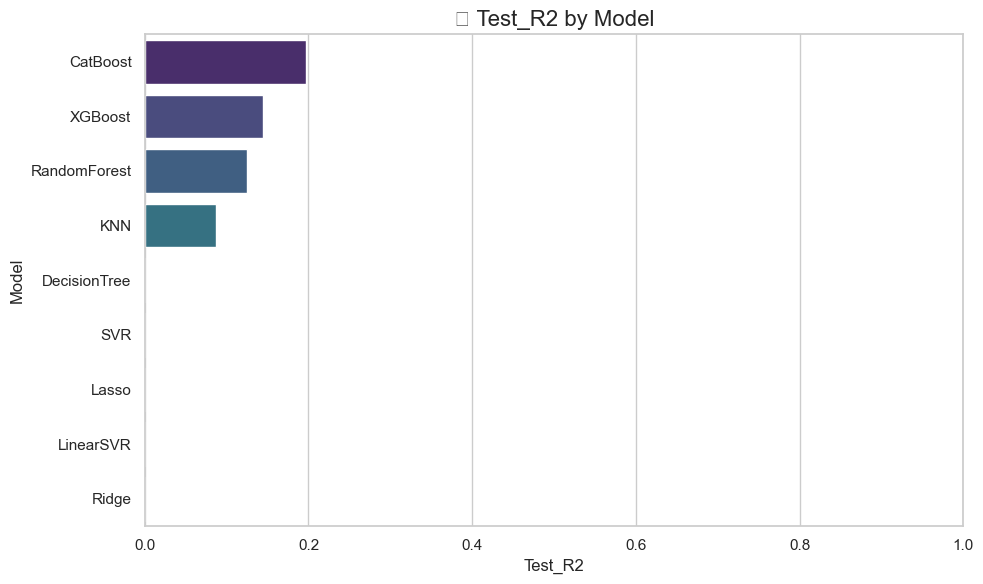

C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y="Model", data=results_df_sorted, palette="viridis")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


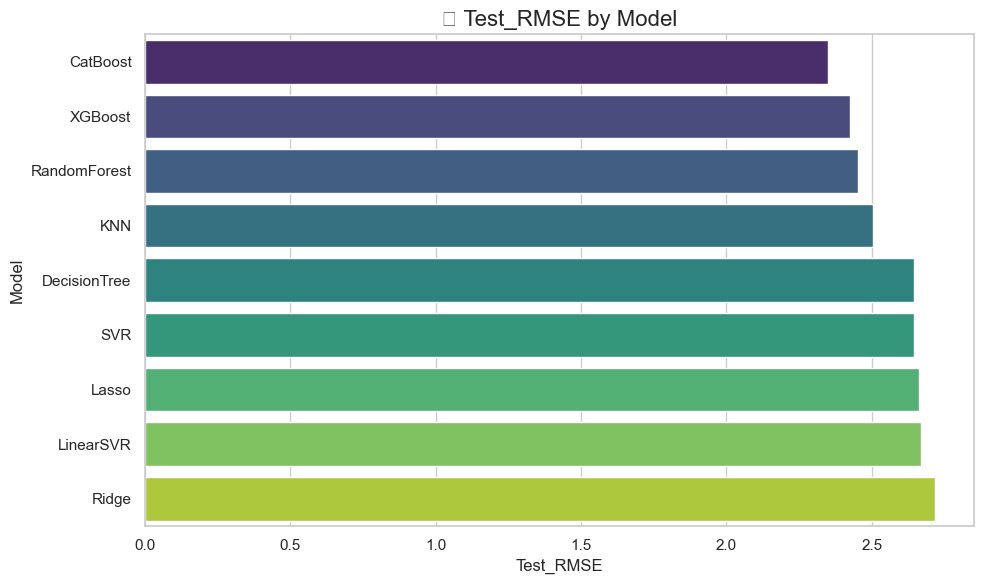

C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y="Model", data=results_df_sorted, palette="viridis")
C:\Users\Jiyoon\AppData\Local\Temp\ipykernel_53912\1924583613.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Jiyoon\anaconda3\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


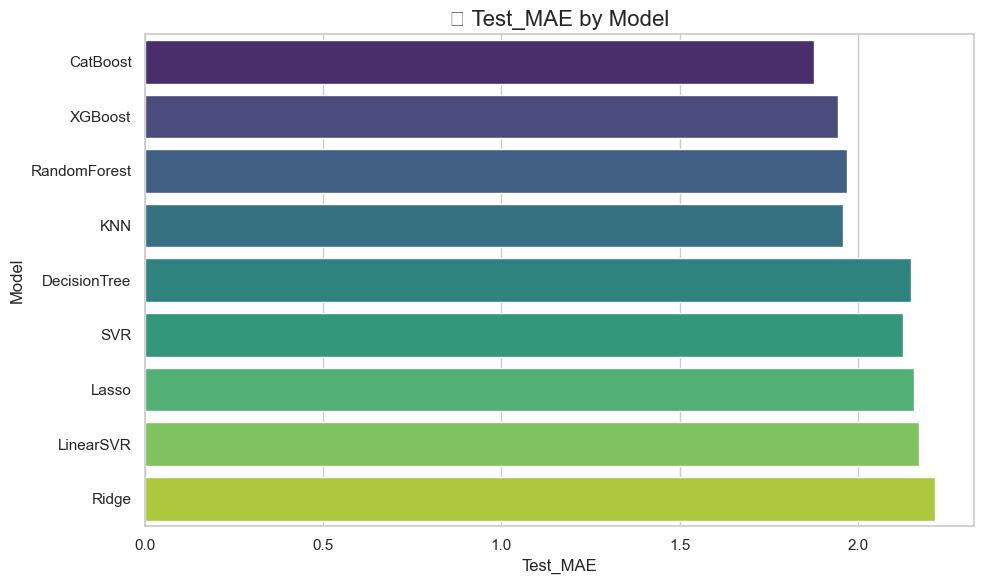

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 이름을 정렬된 순서로 보기 좋게 정렬
results_df_sorted = results_df.sort_values(by="Test_R2", ascending=False)

# 스타일 설정
sns.set(style="whitegrid")
metric_list = ["Test_R2", "Test_RMSE", "Test_MAE"]

# 3개 지표를 각각 시각화
for metric in metric_list:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metric, y="Model", data=results_df_sorted, palette="viridis")
    plt.title(f"📊 {metric} by Model", fontsize=16)
    plt.xlabel(metric)
    plt.ylabel("Model")
    if metric == "Test_R2":
        plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from itertools import combinations

# === 설정 ===
target_model = RandomForestRegressor(**best_params, random_state=42)  # 이전에 튜닝된 best_params 사용
modalities = {
    "EDA": ["EDA_"],
    "PPG": ["PPG_"],
    "RSA": ["RSP_", "RSA_"],
    "Eye": ["eye_", "gaze_", "pupil", "valid"]
}

# === modality 조합 생성 ===
modality_names = list(modalities.keys())
modality_combos = []
for r in range(1, len(modality_names)+1):
    modality_combos += list(combinations(modality_names, r))

# === helper: column 추출 ===
def get_columns_for_modalities(combo, all_columns):
    matched_cols = []
    for modality in combo:
        for prefix in modalities[modality]:
            matched_cols += [col for col in all_columns if col.startswith(prefix)]
    return list(sorted(set(matched_cols)))

# === 결과 저장용 ===
results = []

for combo in modality_combos:
    selected_cols = get_columns_for_modalities(combo, X_full.columns)
    if len(selected_cols) < 2:
        continue

    X_train = pd.concat(split_dfs["Train"])[selected_cols]
    X_val = pd.concat(split_dfs["Val"])[selected_cols]
    X_test = pd.concat(split_dfs["Test"])[selected_cols]

    y_train = pd.concat(split_dfs["Train"])["anxiety_mean"]
    y_val = pd.concat(split_dfs["Val"])["anxiety_mean"]
    y_test = pd.concat(split_dfs["Test"])["anxiety_mean"]

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Fit model
    model = RandomForestRegressor(**best_params, random_state=42)
    model.fit(np.vstack([X_train_scaled, X_val_scaled]), np.hstack([y_train, y_val]))

    # Evaluate
    y_pred_train = model.predict(X_train_scaled)
    y_pred_val = model.predict(X_val_scaled)
    y_pred_test = model.predict(X_test_scaled)

    results.append({
        "Modality": "+".join(combo),
        "R2_Train": r2_score(y_train, y_pred_train),
        "R2_Val": r2_score(y_val, y_pred_val),
        "R2_Test": r2_score(y_test, y_pred_test),
        "RMSE_Test": mean_squared_error(y_test, y_pred_test, squared=False),
        "MAE_Test": mean_absolute_error(y_test, y_pred_test)
    })

# === 결과 DataFrame 출력 ===
result_df = pd.DataFrame(results)
print("📊 Best 모델 기반 modality 조합별 성능 요약:")
print(result_df.sort_values("R2_Test", ascending=False))

# === 라인 플롯 ===
plt.figure(figsize=(10, 6))
for metric in ["R2_Train", "R2_Val", "R2_Test"]:
    plt.plot(result_df["Modality"], result_df[metric], marker='o', label=metric)

plt.title("Modality 조합별 R2 Score (Train / Val / Test)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("R² Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
